# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook or source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [1]:
from skorch import NeuralNetRegressor

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
import sklearn.metrics as metrics
from skorch import NeuralNetRegressor

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

How to load the data:

In [170]:
train_df = pd.read_csv('regression_dataset/train_data.csv')

In [171]:
train_df.head(5)

,input,label
0,-4.787870,-1.216804
1,-3.509057,3.277581
2,-3.855373,2.621375
3,-4.083518,1.046088
4,-4.230588,1.228874


In [172]:
test_df = pd.read_csv('regression_dataset/test_data.csv')
test_df.head(5)

,input,label
0,-0.623168,2.908782
1,4.613433,4.961119
2,4.233314,3.403159
3,-4.555919,-0.606397
4,2.894684,1.397028


In [173]:
train_df.shape

(100, 2)

In [174]:
test_df.shape

(100, 2)

In [175]:
X_train = train_df.drop('label', axis=1 ).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1 ).values
y_test = test_df['label'].values

from sklearn import preprocessing

X_train = X_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)

X_test = X_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# I have normalized the dataset by using StandardScaler() in order to get better results

scaler = preprocessing.StandardScaler().fit(X_train)
scaler = preprocessing.StandardScaler().fit(y_train)

scaler = preprocessing.StandardScaler().fit(X_test)
scaler = preprocessing.StandardScaler().fit(y_test)

X_train = scaler.transform(X_train)
y_train = scaler.transform(y_train)

X_test = scaler.transform(X_test)
y_test = scaler.transform(y_test)

In [176]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.FloatTensor(y_train).reshape(-1,1)
y_test = torch.FloatTensor(y_test).reshape(-1,1)

In [177]:
from torch.utils.data import TensorDataset, DataLoader

In [178]:
train_data = train_df.drop('label', axis=1).values
train_labels = train_df['label'].values

test_data = test_df.drop('label', axis=1).values
test_labels = test_df['label'].values

dataset_train = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
dataset_test = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

How to get a specific sample:

All training points:

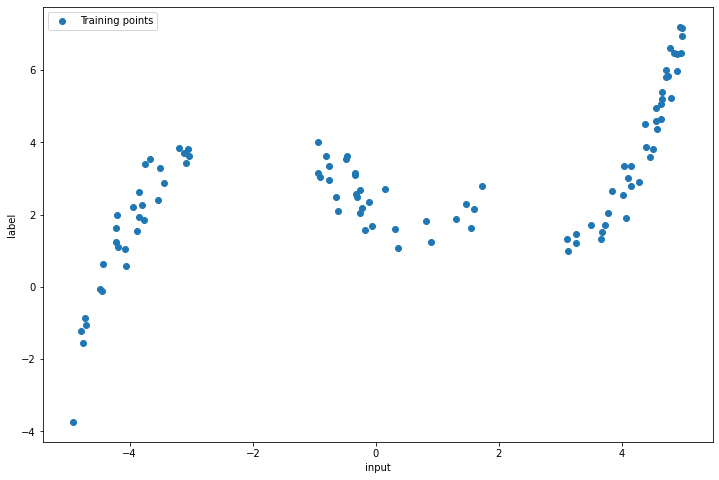

In [179]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

In [180]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


**MY CODES**

**DEFINING REGRESSION MODELS  & UNDERSTANDING EFFECT OF TRAINING**

First I will first define a very basic model in order to show how does the training process effects tuning of hyperparamters. Second I'll define another more complex regression model which also consist of Dropout regularization effect. Then I'll compare these two in my homework report.

In [181]:
#Defining a very basic model to understand what does training change

class BasicRegressionModel(nn.Module):
      def __init__(self,in_features,out_features):
          super().__init__()
          self.linear = nn.Linear(in_features, out_features)

      def forward(self,x):
          y_pred = self.linear(x)
          return y_pred          

In [182]:
# Getting the initial weight and bias (randomly initialized)
model_reg = BasicRegressionModel(1,1)

w1 = model_reg.linear.weight
b1 = model_reg.linear.bias

for name, param in model_reg.named_parameters():
    print(name, 't', param.item())

linear.weight t -0.5303785800933838
linear.bias t 0.6758649349212646


In [183]:
x = torch.tensor([input],dtype=torch.float)
type(x)
print(model_reg.forward(x))

# we did not train yet
# plotting the initial WITHOUT TRANING 

tensor([3.2152], grad_fn=<AddBackward0>)


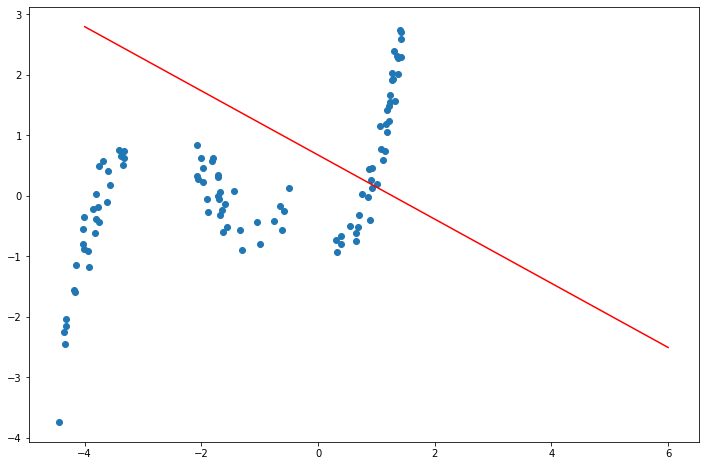

In [184]:
fig = plt.figure(figsize=(12,8))
plt.scatter(X_train.numpy(),y_train.numpy())
x1 = np.linspace(-4.0,6.0)
y1 = w1.item()*x1 + b1.item()
plt.plot(x1, y1, color='r')

In [185]:
#Using the Mean Squared Loss Error

criterion = nn.MSELoss()

In [186]:
# Defining an optimizer for the basic model

optimizer = torch.optim.SGD(model_reg.parameters(),lr=0.01)

In [187]:
# Performance on Train Data

epochs = 500

losses = []

for i in range(epochs):
    #predicting on the forward pass
    y_pred = model_reg.forward(X_train)
    #calculate our loss(error)
    loss=criterion(y_pred,y_train.float())
    #record that error
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(f"epoch{i} loss: { loss.item()} weight: {model_reg.linear.weight.item()} bias: {model_reg.linear.bias.item()}") 

epoch499 loss: 0.8263208866119385 weight: 0.345596581697464 bias: 0.567397952079773


Text(0.5, 0, 'Epoch')

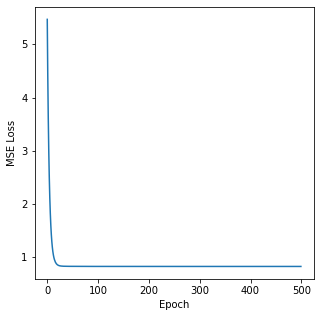

In [188]:
fig = plt.figure(figsize=(5,5))

losses_list = []

for i in range(0,len(losses)):
    losses_list.append(losses[i].item())
    
plt.plot(range(epochs),losses_list)    
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')


In [189]:
# Performance on the Test data

current_weight = model.linear.weight.item()
current_bias = model.linear.bias.item()

predicted_y = current_weight*X_test + current_bias

Text(0, 0.5, 'MSE Loss')

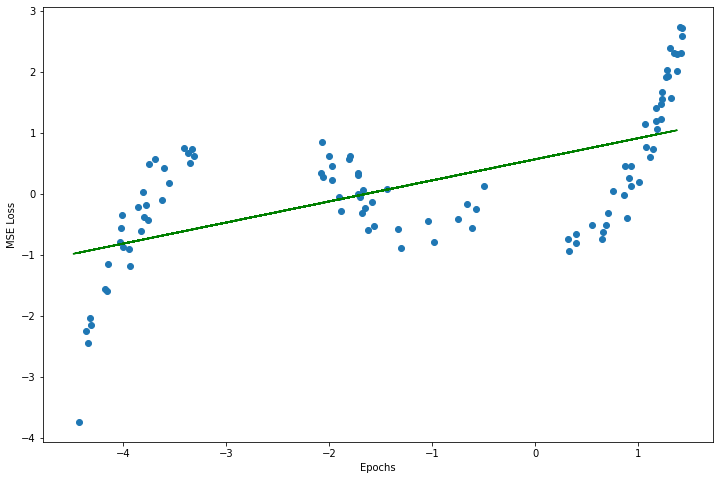

In [190]:
fig = plt.figure(figsize=(12,8))
plt.scatter(X_train.numpy(),y_train.numpy())
plt.plot(X_test.numpy(),predicted_y.numpy(),color='green')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

**A MORE COMPLEX AND REGULARIZED REGRESSION NETWORK MODEL**

**Adding cross - validation, dropout, gridsearch and different optimizers with regression models**

In [141]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

In [142]:

class LinearRegressorRegularized(nn.Module):
    def __init__(self,num_units=10,nonlin=F.relu,drop=.5):
        super(LinearRegressorRegularized,self).__init__()
        
        self.module = nn.Sequential(
            nn.Linear(1,num_units),
            nn.LeakyReLU(),
            nn.Dropout(p=drop),
            nn.Linear(num_units,1),
        )
        
    def forward(self,X):
        X = self.module(X)
        return X

torch.manual_seed(0)

net = NeuralNetRegressor(
    LinearRegressorRegularized,
    criterion=nn.MSELoss,
    optimizer=optim.SGD,
)



params = { 'lr' : [0.01,0.001,0.005,0.1], 'max_epochs': [50,100,150]}

grid_model = GridSearchCV(net,params,refit=True,scoring='r2',verbose=1,cv=4)

grid_model.fit(X_train, y_train )



Fitting 4 folds for each of 12 candidates, totalling 48 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.6907        0.2342  0.0036
      2        1.4858        0.2293  0.0048
      3        1.5723        0.2235  0.0042
      4        1.4677        0.2179  0.0044
      5        1.5653        0.2144  0.0039
      6        1.3858        0.2104  0.0036
      7        1.4098        0.2057  0.0031
      8        1.2156        0.1983  0.0030
      9        1.0923        0.1930  0.0027
     10        1.0780        0.1902  0.0038
     11        1.0733        0.1883  0.0040
     12        1.0325        0.1856  0.0031
     13        1.1770        0.1842  0.0032
     14        0.8511        0.1834  0.0026
     15        1.0089        0.1826  0.0022
     16        0.9594        0.1828  0.0026
     17        0.9963        0.1825  0.0022
     18        0.8509        0.1823  0.0023
     19        0.8499        0.1826  0.0026
     20        

      6        1.0175        0.9942  0.0025
      7        1.0653        0.9811  0.0023
      8        0.9962        1.0262  0.0036
      9        1.1891        1.1193  0.0026
     10        1.1141        1.0281  0.0030
     11        0.8999        1.0253  0.0054
     12        0.9784        0.9798  0.0031
     13        1.0438        1.0155  0.0025
     14        0.9057        0.9905  0.0021
     15        0.9705        0.9662  0.0023
     16        0.9631        0.9707  0.0023
     17        1.0303        0.9325  0.0023
     18        1.0063        0.9346  0.0033
     19        0.9247        0.9347  0.0028
     20        0.9008        0.9313  0.0027
     21        0.8800        0.8948  0.0025
     22        0.8507        0.8981  0.0028
     23        0.9095        0.9011  0.0024
     24        0.9476        0.8986  0.0037
     25        0.8913        0.8944  0.0027
     26        0.8707        0.8962  0.0024
     27        1.0311        0.9403  0.0043
     28        0.8663        0.9

     23        1.1480        0.8464  0.0025
     24        1.1686        0.8478  0.0027
     25        1.2958        0.8486  0.0023
     26        1.0266        0.8469  0.0036
     27        0.9408        0.8464  0.0025
     28        0.9450        0.8451  0.0029
     29        1.2295        0.8405  0.0022
     30        1.2663        0.8421  0.0023
     31        1.0736        0.8396  0.0024
     32        1.1724        0.8388  0.0026
     33        0.8985        0.8392  0.0033
     34        1.1901        0.8390  0.0028
     35        1.1698        0.8392  0.0026
     36        1.0090        0.8388  0.0025
     37        1.2357        0.8394  0.0030
     38        1.0341        0.8408  0.0025
     39        1.0578        0.8423  0.0031
     40        0.8483        0.8434  0.0036
     41        1.1024        0.8423  0.0026
     42        0.9270        0.8463  0.0026
     43        1.1001        0.8438  0.0026
     44        0.8944        0.8483  0.0027
     45        1.2373        0.8

     98        0.9249        0.8888  0.0029
     99        0.7732        0.8512  0.0029
    100        0.8301        0.8433  0.0023
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.9049        2.9927  0.0019
      2        1.4748        2.2368  0.0026
      3        1.3234        1.7479  0.0036
      4        1.2650        1.5254  0.0024
      5        1.1053        1.2729  0.0023
      6        0.8602        1.2623  0.0024
      7        1.1366        1.1775  0.0030
      8        1.1613        1.1445  0.0035
      9        1.0294        1.1148  0.0025
     10        1.1130        1.0888  0.0027
     11        0.9714        1.0869  0.0028
     12        1.0591        1.0412  0.0025
     13        0.9234        1.0633  0.0037
     14        0.9563        0.9961  0.0043
     15        0.9622        0.9510  0.0032
     16        0.9395        0.9618  0.0037
     17        0.9336        0.9367  0.0036
     18        1.0113        0.9

     59        0.8917        0.2852  0.0025
     60        0.8838        0.2838  0.0033
     61        1.0415        0.2844  0.0025
     62        0.7824        0.2814  0.0024
     63        0.9277        0.2798  0.0030
     64        1.0192        0.2757  0.0028
     65        0.9104        0.2723  0.0023
     66        0.8894        0.2713  0.0033
     67        0.9155        0.2708  0.0027
     68        0.7879        0.2684  0.0028
     69        0.9106        0.2661  0.0029
     70        0.9927        0.2638  0.0027
     71        0.8808        0.2612  0.0036
     72        0.8136        0.2572  0.0027
     73        0.7347        0.2545  0.0047
     74        0.8587        0.2516  0.0027
     75        0.9604        0.2534  0.0023
     76        0.8834        0.2521  0.0028
     77        0.9221        0.2505  0.0025
     78        0.8929        0.2484  0.0029
     79        0.8890        0.2449  0.0031
     80        0.9121        0.2421  0.0025
     81        0.8168        0.2

     72        1.1827        0.8219  0.0026
     73        1.1095        0.8069  0.0026
     74        1.1295        0.7974  0.0026
     75        1.1605        0.7959  0.0025
     76        0.8645        0.7976  0.0023
     77        1.0568        0.7901  0.0026
     78        0.9781        0.7875  0.0028
     79        1.0881        0.8075  0.0025
     80        1.1571        0.8156  0.0022
     81        1.0979        0.8251  0.0033
     82        1.0153        0.8337  0.0025
     83        1.0056        0.8260  0.0021
     84        0.9239        0.8570  0.0021
     85        1.1474        0.8220  0.0021
     86        1.1845        0.8351  0.0023
     87        1.1774        0.8293  0.0021
     88        0.9438        0.8253  0.0025
     89        1.1613        0.8305  0.0023
     90        0.9991        0.8302  0.0024
     91        1.2104        0.8391  0.0023
     92        1.0726        0.8203  0.0024
     93        0.9156        0.8263  0.0025
     94        1.0126        0.8

    104        0.8551        0.8340  0.0023
    105        0.7889        0.8214  0.0022
    106        0.8255        0.8176  0.0026
    107        0.7486        0.8033  0.0023
    108        0.8827        0.8227  0.0033
    109        0.9244        0.8374  0.0024
    110        0.7125        0.8313  0.0026
    111        0.7508        0.8246  0.0036
    112        0.9367        0.8390  0.0024
    113        0.9471        0.8546  0.0027
    114        0.8981        0.8509  0.0024
    115        0.7335        0.8332  0.0034
    116        0.7671        0.8362  0.0030
    117        0.8626        0.8416  0.0024
    118        0.7925        0.8499  0.0030
    119        1.0502        0.8714  0.0028
    120        0.9547        0.8817  0.0027
    121        0.9248        0.8711  0.0024
    122        0.9539        0.8631  0.0035
    123        0.7849        0.8445  0.0023
    124        0.7633        0.8370  0.0033
    125        0.8438        0.8323  0.0025
    126        0.9433        0.8

    130        0.8945        0.8972  0.0023
    131        0.8358        0.9021  0.0024
    132        0.8314        0.9084  0.0029
    133        0.9066        0.9223  0.0030
    134        0.8313        0.9254  0.0026
    135        0.8055        0.9398  0.0026
    136        0.8623        0.9346  0.0037
    137        0.7526        0.9057  0.0031
    138        0.8229        0.8952  0.0033
    139        0.7750        0.8685  0.0026
    140        0.8939        0.8850  0.0026
    141        0.8481        0.8790  0.0025
    142        0.8461        0.8959  0.0031
    143        0.8508        0.8871  0.0022
    144        0.7211        0.8624  0.0023
    145        0.8337        0.8537  0.0034
    146        0.9126        0.8531  0.0030
    147        0.8578        0.8810  0.0026
    148        0.7123        0.8730  0.0024
    149        0.8144        0.8722  0.0032
    150        0.7953        0.8784  0.0026
  epoch    train_loss    valid_loss     dur
-------  ------------  ---------

     32        1.7247        0.8701  0.0031
     33        1.3450        0.8714  0.0028
     34        1.8335        0.8735  0.0025
     35        1.4881        0.8774  0.0026
     36        1.3988        0.8754  0.0026
     37        1.7518        0.8814  0.0025
     38        1.4256        0.8828  0.0034
     39        1.6482        0.8872  0.0027
     40        1.3372        0.8933  0.0028
     41        1.2644        0.8984  0.0024
     42        1.7564        0.8951  0.0027
     43        1.5483        0.8965  0.0026
     44        1.5195        0.8946  0.0029
     45        1.1843        0.8989  0.0032
     46        1.3036        0.9040  0.0026
     47        1.2536        0.9072  0.0027
     48        1.2689        0.9092  0.0025
     49        1.3770        0.9137  0.0028
     50        1.4349        0.9206  0.0024
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.8489        1.2541  0.0018
      2        2.0883        1.2

      2        1.2948        0.9646  0.0034
      3        1.2025        0.9640  0.0033
      4        1.1438        0.9613  0.0049
      5        1.4833        0.9606  0.0042
      6        1.1897        0.9591  0.0032
      7        1.3761        0.9585  0.0034
      8        1.1668        0.9586  0.0039
      9        1.1201        0.9569  0.0035
     10        1.1348        0.9555  0.0034
     11        1.4264        0.9543  0.0033
     12        1.6205        0.9556  0.0049
     13        1.2966        0.9547  0.0034
     14        1.1724        0.9528  0.0033
     15        1.3447        0.9502  0.0038
     16        1.0711        0.9486  0.0038
     17        1.1766        0.9483  0.0030
     18        1.1789        0.9473  0.0029
     19        1.2572        0.9461  0.0032
     20        1.0611        0.9442  0.0026
     21        1.3932        0.9437  0.0034
     22        1.2376        0.9426  0.0026
     23        1.2679        0.9409  0.0028
     24        1.2985        0.9

     63        0.9709        0.8608  0.0024
     64        1.2249        0.8651  0.0025
     65        1.4408        0.8673  0.0023
     66        1.0377        0.8675  0.0021
     67        1.2452        0.8741  0.0023
     68        1.2814        0.8796  0.0021
     69        1.1839        0.8809  0.0021
     70        1.2614        0.8862  0.0022
     71        1.1562        0.8850  0.0023
     72        1.2507        0.8861  0.0022
     73        1.2714        0.8848  0.0021
     74        1.0934        0.8860  0.0023
     75        1.1233        0.8887  0.0023
     76        1.1103        0.8853  0.0023
     77        1.1097        0.8854  0.0023
     78        1.3147        0.8927  0.0023
     79        1.2955        0.8910  0.0023
     80        1.1387        0.8973  0.0024
     81        1.0759        0.8971  0.0023
     82        1.1383        0.8974  0.0023
     83        1.0410        0.8963  0.0022
     84        1.3697        0.9023  0.0022
     85        1.1787        0.9

     34        1.0940        0.1760  0.0043
     35        1.0834        0.1759  0.0025
     36        0.9634        0.1759  0.0026
     37        1.1702        0.1759  0.0027
     38        1.0756        0.1758  0.0028
     39        1.2796        0.1758  0.0034
     40        1.2526        0.1758  0.0027
     41        1.1288        0.1758  0.0027
     42        1.1086        0.1757  0.0028
     43        1.2168        0.1757  0.0034
     44        1.0029        0.1757  0.0044
     45        1.2849        0.1757  0.0028
     46        1.0171        0.1756  0.0030
     47        1.0567        0.1756  0.0034
     48        1.0175        0.1756  0.0030
     49        1.3287        0.1755  0.0028
     50        1.0820        0.1755  0.0025
     51        1.2078        0.1755  0.0040
     52        1.2447        0.1755  0.0028
     53        0.9782        0.1754  0.0032
     54        1.0076        0.1754  0.0028
     55        1.0993        0.1754  0.0025
     56        1.0000        0.1

     47        1.2802        0.9371  0.0073
     48        1.1515        0.9338  0.0035
     49        1.0875        0.9265  0.0029
     50        1.2604        0.9205  0.0028
     51        1.0897        0.9159  0.0026
     52        1.2741        0.9110  0.0027
     53        1.2333        0.9104  0.0025
     54        1.1978        0.9072  0.0030
     55        1.1285        0.9042  0.0026
     56        1.1947        0.8976  0.0029
     57        1.1781        0.8910  0.0026
     58        1.1698        0.8878  0.0027
     59        1.1108        0.8857  0.0028
     60        0.9948        0.8830  0.0026
     61        1.1943        0.8809  0.0029
     62        1.3347        0.8781  0.0027
     63        1.3960        0.8745  0.0030
     64        1.0667        0.8721  0.0029
     65        1.3327        0.8703  0.0028
     66        1.3003        0.8699  0.0031
     67        1.1022        0.8666  0.0031
     68        1.3660        0.8626  0.0043
     69        1.2308        0.8

     61        1.0433        0.9022  0.0029
     62        1.0244        0.9027  0.0030
     63        1.0689        0.9033  0.0034
     64        1.1692        0.9040  0.0032
     65        1.1529        0.9058  0.0030
     66        1.0399        0.9067  0.0028
     67        1.1754        0.9080  0.0027
     68        1.1854        0.9100  0.0028
     69        1.2412        0.9111  0.0028
     70        1.2622        0.9128  0.0027
     71        1.2559        0.9155  0.0029
     72        1.0819        0.9159  0.0031
     73        1.1265        0.9179  0.0032
     74        1.1595        0.9192  0.0030
     75        1.1464        0.9208  0.0032
     76        1.2621        0.9233  0.0026
     77        1.2047        0.9250  0.0025
     78        1.0140        0.9259  0.0032
     79        1.1684        0.9280  0.0029
     80        1.2445        0.9301  0.0025
     81        1.1566        0.9322  0.0024
     82        0.9702        0.9331  0.0029
     83        1.1873        0.9

     85        0.8025        0.8520  0.0028
     86        0.7989        0.8513  0.0024
     87        1.0414        0.8503  0.0023
     88        0.8773        0.8487  0.0022
     89        0.8091        0.8494  0.0023
     90        1.0165        0.8520  0.0029
     91        0.8615        0.8497  0.0037
     92        1.0477        0.8515  0.0025
     93        0.9131        0.8497  0.0025
     94        0.9130        0.8528  0.0024
     95        0.6523        0.8548  0.0029
     96        0.7537        0.8508  0.0033
     97        0.8286        0.8488  0.0030
     98        0.7834        0.8500  0.0028
     99        0.8842        0.8483  0.0035
    100        1.0355        0.8460  0.0035
    101        0.8652        0.8495  0.0038
    102        0.9708        0.8491  0.0028
    103        0.7275        0.8491  0.0032
    104        0.9209        0.8494  0.0034
    105        0.9812        0.8479  0.0030
    106        0.8146        0.8493  0.0026
    107        0.8134        0.8

     49        1.0672        0.8362  0.0026
     50        1.2357        0.8401  0.0029
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.7918        0.8209  0.0020
      2        1.8839        0.8348  0.0029
      3        2.1711        0.8520  0.0025
      4        1.7337        0.8618  0.0027
      5        2.0167        0.8638  0.0026
      6        1.9137        0.8701  0.0028
      7        1.7214        0.8900  0.0026
      8        1.9149        0.8994  0.0027
      9        2.0502        0.9098  0.0026
     10        1.3669        0.9378  0.0023
     11        1.5044        0.9501  0.0025
     12        1.8328        0.9584  0.0024
     13        1.3340        0.9840  0.0026
     14        1.5536        0.9946  0.0025
     15        1.3456        0.9843  0.0022
     16        1.2930        1.0360  0.0026
     17        1.3509        0.9830  0.0026
     18        1.3991        0.9881  0.0036
     19        1.3351        0.9

     54        1.0435        0.3680  0.0029
     55        0.9198        0.3644  0.0034
     56        1.1535        0.3601  0.0029
     57        0.8963        0.3599  0.0028
     58        0.8831        0.3573  0.0029
     59        0.9119        0.3562  0.0041
     60        0.9988        0.3518  0.0033
     61        0.8691        0.3462  0.0027
     62        0.8993        0.3434  0.0027
     63        0.9311        0.3445  0.0033
     64        0.9159        0.3407  0.0030
     65        0.9976        0.3366  0.0029
     66        0.9771        0.3358  0.0030
     67        0.8864        0.3339  0.0034
     68        1.1166        0.3331  0.0140
     69        0.8962        0.3324  0.0051
     70        1.0530        0.3305  0.0039
     71        1.0988        0.3257  0.0070
     72        0.9223        0.3237  0.0032
     73        0.8344        0.3187  0.0038
     74        0.9382        0.3159  0.0033
     75        0.9270        0.3147  0.0033
     76        0.8643        0.3

     16        1.5506        0.8222  0.0023
     17        1.6172        0.8244  0.0025
     18        1.2853        0.8248  0.0030
     19        1.5803        0.8285  0.0026
     20        1.4107        0.8279  0.0025
     21        1.4912        0.8333  0.0025
     22        1.3618        0.8323  0.0028
     23        1.3443        0.8433  0.0025
     24        1.1910        0.8430  0.0036
     25        1.4474        0.8480  0.0027
     26        0.9681        0.8507  0.0026
     27        1.3467        0.8509  0.0026
     28        1.3681        0.8500  0.0031
     29        1.2182        0.8517  0.0025
     30        1.0634        0.8524  0.0025
     31        1.1797        0.8570  0.0023
     32        1.0858        0.8600  0.0027
     33        1.1685        0.8582  0.0026
     34        1.0374        0.8719  0.0038
     35        1.1537        0.8631  0.0030
     36        0.7184        0.8623  0.0030
     37        1.2225        0.8595  0.0033
     38        0.9636        0.8

     95        0.9312        0.8801  0.0036
     96        0.8596        0.8770  0.0032
     97        0.8789        0.8805  0.0035
     98        0.8505        0.8823  0.0028
     99        0.8910        0.8888  0.0039
    100        0.7604        0.8835  0.0039
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.6568        0.1986  0.0021
      2        1.2358        0.1983  0.0036
      3        1.5565        0.1952  0.0035
      4        1.3172        0.1962  0.0028
      5        1.2835        0.1967  0.0026
      6        1.2331        0.1950  0.0039
      7        1.2638        0.1961  0.0028
      8        1.2119        0.1957  0.0040
      9        1.3507        0.1934  0.0029
     10        1.1523        0.1914  0.0029
     11        1.2009        0.1918  0.0026
     12        1.2637        0.1905  0.0030
     13        1.1245        0.1906  0.0036
     14        1.1996        0.1882  0.0029
     15        1.0744        0.1

     15        1.6268        0.8291  0.0030
     16        1.6911        0.8215  0.0034
     17        1.5498        0.8214  0.0032
     18        1.8054        0.8139  0.0032
     19        1.6052        0.8114  0.0031
     20        1.5116        0.8125  0.0035
     21        1.6706        0.8081  0.0032
     22        1.6696        0.8078  0.0030
     23        1.4207        0.8078  0.0039
     24        1.5893        0.8069  0.0032
     25        1.3656        0.8074  0.0044
     26        1.2213        0.8061  0.0032
     27        1.4419        0.8045  0.0030
     28        1.3993        0.8051  0.0047
     29        1.3928        0.8054  0.0031
     30        1.4214        0.8042  0.0030
     31        1.5751        0.8020  0.0034
     32        1.3391        0.8018  0.0038
     33        1.4860        0.8002  0.0030
     34        1.1871        0.8000  0.0033
     35        1.3500        0.7993  0.0037
     36        1.3215        0.7987  0.0030
     37        1.3254        0.7

     35        0.9435        1.0824  0.0034
     36        1.1174        1.0775  0.0044
     37        0.8599        1.0681  0.0034
     38        0.8323        1.0566  0.0033
     39        0.9761        1.0504  0.0039
     40        0.9208        1.0547  0.0032
     41        0.6847        1.0412  0.0034
     42        0.9970        1.0290  0.0029
     43        0.9728        1.0188  0.0036
     44        0.7957        1.0070  0.0030
     45        0.8702        0.9987  0.0036
     46        0.8551        0.9941  0.0042
     47        1.0390        0.9829  0.0037
     48        0.9729        0.9707  0.0030
     49        0.6643        0.9604  0.0031
     50        0.7931        0.9563  0.0033
     51        0.8915        0.9534  0.0040
     52        0.8761        0.9500  0.0033
     53        0.7662        0.9363  0.0035
     54        0.8321        0.9275  0.0039
     55        0.7120        0.9227  0.0029
     56        0.8214        0.9190  0.0035
     57        0.8489        0.9

     57        0.8987        0.8446  0.0042
     58        0.9217        0.8434  0.0034
     59        0.9157        0.8501  0.0039
     60        0.8228        0.8423  0.0036
     61        0.9568        0.8483  0.0034
     62        0.8898        0.8526  0.0039
     63        0.8325        0.8524  0.0043
     64        0.8412        0.8547  0.0042
     65        0.8686        0.8556  0.0045
     66        0.8404        0.8531  0.0041
     67        0.9415        0.8729  0.0037
     68        0.8155        0.8591  0.0036
     69        0.8937        0.8516  0.0034
     70        0.8366        0.8464  0.0038
     71        0.8757        0.8426  0.0030
     72        0.8729        0.8348  0.0035
     73        0.9087        0.8390  0.0037
     74        0.9139        0.8490  0.0031
     75        0.8593        0.8382  0.0030
     76        0.8678        0.8459  0.0027
     77        0.8383        0.8521  0.0040
     78        0.8192        0.8524  0.0030
     79        0.8666        0.8

     33        1.0221        0.8522  0.0031
     34        0.8147        0.9023  0.0034
     35        0.6171        0.9785  0.0031
     36        0.5652        0.9944  0.0044
     37        0.7636        0.8256  0.0031
     38        0.7626        0.8609  0.0037
     39        0.8339        0.8841  0.0033
     40        0.8123        0.8725  0.0029
     41        0.9355        0.8892  0.0042
     42        0.7997        1.0085  0.0032
     43        1.0153        0.8279  0.0039
     44        0.9235        0.8020  0.0030
     45        0.7116        0.8261  0.0030
     46        0.8230        0.8520  0.0044
     47        0.9280        0.8153  0.0039
     48        1.0010        0.8756  0.0032
     49        0.9205        0.8837  0.0042
     50        0.7372        0.8641  0.0036
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.2415        1.1302  0.0031
      2        1.2729        0.8809  0.0036
      3        0.7180        0.8

     51        0.7601        0.2502  0.0040
     52        0.7184        0.2477  0.0049
     53        0.6591        0.2427  0.0032
     54        0.6466        0.2370  0.0041
     55        0.7526        0.2473  0.0035
     56        0.5812        0.2341  0.0034
     57        0.6626        0.2581  0.0036
     58        0.4790        0.2379  0.0036
     59        0.6440        0.2477  0.0034
     60        0.7766        0.2386  0.0036
     61        0.6656        0.2431  0.0033
     62        0.5479        0.2426  0.0039
     63        0.6911        0.2337  0.0033
     64        0.5123        0.2343  0.0033
     65        0.7895        0.2185  0.0033
     66        0.5467        0.2444  0.0037
     67        0.6701        0.2257  0.0032
     68        0.5045        0.2312  0.0038
     69        0.6297        0.2403  0.0054
     70        0.5973        0.2259  0.0035
     71        0.8883        0.2182  0.0032
     72        0.7010        0.2111  0.0038
     73        0.8100        0.2

     25        0.7953        0.7872  0.0041
     26        0.6240        0.7809  0.0042
     27        0.6953        0.7647  0.0033
     28        0.7757        0.8192  0.0030
     29        0.6035        0.7693  0.0029
     30        0.7510        0.7667  0.0027
     31        0.7427        0.7995  0.0029
     32        0.8169        0.7689  0.0027
     33        0.8240        0.7796  0.0037
     34        0.6430        0.7590  0.0029
     35        0.6575        0.7514  0.0033
     36        0.6442        0.7639  0.0033
     37        0.6705        0.7499  0.0030
     38        0.7897        0.7657  0.0028
     39        0.6931        0.7487  0.0043
     40        0.7233        0.9228  0.0030
     41        0.6910        0.7685  0.0028
     42        0.8076        0.7465  0.0028
     43        0.5122        0.7429  0.0041
     44        0.8156        0.7657  0.0038
     45        0.6990        0.8058  0.0031
     46        0.7954        0.7785  0.0185
     47        0.6822        0.7

     99        0.5453        0.7447  0.0040
    100        0.6299        0.7500  0.0037
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.4175        0.1960  0.0025
      2        1.1005        0.1881  0.0040
      3        0.9351        0.1912  0.0030
      4        0.9244        0.1898  0.0036
      5        1.0609        0.1911  0.0035
      6        0.8666        0.1878  0.0033
      7        0.9977        0.1909  0.0034
      8        1.1846        0.1878  0.0035
      9        0.9851        0.1867  0.0030
     10        0.8117        0.1857  0.0032
     11        0.8653        0.1871  0.0033
     12        0.7883        0.1894  0.0037
     13        0.7210        0.1906  0.0034
     14        0.7261        0.1891  0.0033
     15        0.8735        0.1903  0.0048
     16        0.8093        0.1907  0.0044
     17        0.8591        0.1924  0.0029
     18        0.8137        0.1899  0.0039
     19        0.8276        0.1

     25        0.7569        0.9536  0.0041
     26        0.6743        0.9385  0.0036
     27        0.8286        1.0357  0.0044
     28        0.7675        0.9862  0.0040
     29        0.8969        0.8375  0.0044
     30        0.6282        1.0177  0.0045
     31        0.8373        0.9956  0.0039
     32        0.6923        0.8949  0.0032
     33        0.9189        0.9942  0.0043
     34        0.8889        0.8226  0.0032
     35        0.8871        0.8284  0.0038
     36        0.8067        0.9865  0.0041
     37        0.6719        0.8493  0.0048
     38        0.8697        0.8007  0.0039
     39        0.5681        1.1176  0.0038
     40        0.7893        0.7914  0.0036
     41        0.7827        0.8242  0.0033
     42        0.7177        0.9891  0.0043
     43        0.7034        1.1518  0.0032
     44        0.6774        1.0279  0.0036
     45        0.7146        0.7991  0.0040
     46        0.7153        1.0013  0.0030
     47        0.7536        0.8

     56        0.7074        0.7569  0.0036
     57        0.6874        0.7565  0.0037
     58        0.6690        0.7911  0.0042
     59        0.6514        0.7448  0.0038
     60        0.6312        0.7766  0.0045
     61        0.6829        0.7695  0.0039
     62        0.8013        0.7176  0.0036
     63        0.7264        0.7326  0.0032
     64        0.7063        0.7102  0.0032
     65        0.6709        0.7713  0.0032
     66        0.6470        0.7402  0.0040
     67        0.8508        0.7351  0.0046
     68        0.6153        0.7227  0.0032
     69        0.4554        0.7046  0.0032
     70        0.7022        0.7318  0.0039
     71        0.5612        0.7210  0.0038
     72        0.6202        0.7026  0.0048
     73        0.5243        0.7019  0.0037
     74        0.5828        0.7138  0.0049
     75        0.8730        0.7611  0.0037
     76        0.6411        0.7513  0.0045
     77        0.6938        0.7161  0.0036
     78        0.7962        0.7

     85        0.7899        0.9913  0.0041
     86        0.6730        0.9628  0.0045
     87        0.7216        0.9300  0.0039
     88        0.8274        0.9758  0.0031
     89        0.6896        0.9726  0.0042
     90        0.7316        0.9578  0.0034
     91        0.7220        0.9721  0.0034
     92        0.7485        0.9662  0.0032
     93        0.7449        0.9741  0.0038
     94        0.8024        0.9961  0.0035
     95        0.7486        1.0210  0.0039
     96        0.7785        1.0253  0.0034
     97        0.7190        0.9958  0.0050
     98        0.6604        1.0138  0.0036
     99        0.7248        0.9746  0.0050
    100        0.6596        0.9621  0.0042
    101        0.7889        0.9769  0.0050
    102        0.5768        0.9403  0.0039
    103        0.6928        0.9645  0.0050
    104        0.7007        0.9708  0.0044
    105        0.7324        0.9311  0.0061
    106        0.6472        0.9243  0.0038
    107        0.9016        0.9

GridSearchCV(cv=4,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.LinearRegressorRegularized'>,
),
             param_grid={'lr': [0.01, 0.001, 0.005, 0.1],
                         'max_epochs': [50, 100, 150]},
             scoring='r2', verbose=1)

In [31]:
LinearRegressorRegularized()

LinearRegressorRegularized(
  (module): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [149]:
print("Best parameters set found:")

print(grid_model.best_params_)

print("Score with best parameters:")

print(abs(grid_model.best_score_))

print("All scores on the grid:")

all_scores = pd.DataFrame(grid_model.cv_results_)

all_scores

Best parameters set found:
{'lr': 0.1, 'max_epochs': 50}
Score with best parameters:
0.9552145518005946
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_max_epochs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.221071,0.004125,0.002145,0.000738,0.01,50,"{'lr': 0.01, 'max_epochs': 50}",-0.215336,-1.485892,-0.250551,-2.184974,-1.034188,0.838593,4
1,0.430074,0.010615,0.001851,0.000355,0.01,100,"{'lr': 0.01, 'max_epochs': 100}",-0.154086,-3.441302,-0.553085,-1.080423,-1.307224,1.275165,10
2,0.668687,0.018258,0.001882,0.000143,0.01,150,"{'lr': 0.01, 'max_epochs': 150}",-1.010992,-2.228641,-0.522122,-1.159781,-1.230384,0.622750,8
3,0.217491,0.009831,0.002270,0.000251,0.001,50,"{'lr': 0.001, 'max_epochs': 50}",-0.388964,-0.195837,0.080461,-6.249058,-1.688349,2.638406,12
4,0.465859,0.054156,0.001753,0.000241,0.001,100,"{'lr': 0.001, 'max_epochs': 100}",-1.264949,-0.794489,-0.054868,-2.095634,-1.052485,0.740794,5
5,0.737360,0.021654,0.002336,0.000482,0.001,150,"{'lr': 0.001, 'max_epochs': 150}",-0.840832,-2.435898,0.221945,-1.013046,-1.016958,0.945953,3
6,0.231223,0.012451,0.002172,0.000178,0.005,50,"{'lr': 0.005, 'max_epochs': 50}",-0.499448,-2.723639,-0.063711,-1.854626,-1.285356,1.060989,9
7,0.510588,0.034107,0.002170,0.000120,0.005,100,"{'lr': 0.005, 'max_epochs': 100}",-0.157227,-2.557342,0.054967,-1.315081,-0.993671,1.042551,2
8,0.818260,0.017718,0.002565,0.000434,0.005,150,"{'lr': 0.005, 'max_epochs': 150}",-0.079628,-2.410939,-0.047748,-2.126486,-1.166200,1.107147,7
9,0.258423,0.017015,0.002350,0.000270,0.1,50,"{'lr': 0.1, 'max_epochs': 50}",-0.104738,-2.736456,-0.020391,-0.959274,-0.955215,1.092021,1


In [144]:
# Trying to train with another optimizer Adam Optimizer, the previous one was SGD
# Observe the same parameters & scores grid and compare these two

model2 = LinearRegressorRegularized()

net2 = NeuralNetRegressor(model2, verbose=1, optimizer=torch.optim.Adam)
#By default, 20% of the incoming data is reserved for validation

params = { 'lr' : [0.01,0.001,0.005,0.1], 'max_epochs': [50,100,150]}

grid_model2 = GridSearchCV(net2,params,refit=True,scoring='r2',verbose=1,cv=4)

grid_model2.fit(X_train, y_train )

Fitting 4 folds for each of 12 candidates, totalling 48 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1929        0.4394  0.0052
      2        1.1893        0.3531  0.0052
      3        1.1628        0.3076  0.0041
      4        1.2904        0.2673  0.0044
      5        1.3267        0.2404  0.0046
      6        1.3599        0.2212  0.0036
      7        1.4417        0.2080  0.0032
      8        1.0867        0.2015  0.0032
      9        0.9000        0.1993  0.0029
     10        1.3206        0.1980  0.0024
     11        0.8437        0.2008  0.0027
     12        1.1830        0.2059  0.0025
     13        1.0450        0.2126  0.0032
     14        1.0198        0.2217  0.0037
     15        0.7174        0.2313  0.0027
     16        1.0933        0.2437  0.0027
     17        1.0282        0.2552  0.0029
     18        0.7686        0.2691  0.0034
     19        1.1302        0.2805  0.0033
     20        

     14        0.7911        0.8432  0.0029
     15        0.8843        0.8340  0.0034
     16        0.7330        0.8243  0.0027
     17        0.8767        0.8214  0.0026
     18        0.9198        0.8198  0.0029
     19        0.7397        0.8133  0.0027
     20        0.8095        0.8066  0.0027
     21        0.8211        0.8012  0.0038
     22        0.6668        0.7963  0.0025
     23        0.9302        0.7926  0.0024
     24        0.7841        0.7911  0.0027
     25        0.7395        0.7897  0.0026
     26        0.9823        0.7917  0.0037
     27        0.8621        0.7956  0.0027
     28        0.7641        0.8000  0.0024
     29        0.7124        0.8051  0.0025
     30        0.7290        0.8066  0.0028
     31        0.7498        0.8070  0.0042
     32        0.8567        0.8092  0.0034
     33        0.8051        0.8142  0.0031
     34        0.8147        0.8192  0.0047
     35        0.7624        0.8213  0.0030
     36        0.7330        0.8

     36        1.1324        0.8731  0.0030
     37        1.0420        0.8793  0.0037
     38        0.9954        0.8889  0.0037
     39        0.9582        0.9051  0.0039
     40        1.2217        0.9122  0.0031
     41        1.2345        0.9127  0.0033
     42        1.2566        0.9048  0.0038
     43        1.2093        0.8919  0.0031
     44        1.0549        0.8804  0.0037
     45        1.1375        0.8739  0.0031
     46        1.0376        0.8752  0.0035
     47        1.2480        0.8816  0.0035
     48        0.9321        0.8945  0.0046
     49        0.9164        0.9127  0.0031
     50        1.0964        0.9323  0.0032
     51        1.1343        0.9452  0.0040
     52        1.0818        0.9434  0.0033
     53        1.2523        0.9399  0.0038
     54        1.0233        0.9335  0.0038
     55        1.1029        0.9311  0.0040
     56        1.1397        0.9196  0.0035
     57        0.9589        0.9192  0.0030
     58        1.1132        0.9

      7        0.8630        0.9629  0.0036
      8        0.9907        0.9562  0.0024
      9        0.8457        0.9450  0.0025
     10        1.0184        0.9406  0.0026
     11        0.9679        0.9371  0.0031
     12        0.8421        0.9374  0.0036
     13        0.8415        0.9345  0.0026
     14        0.7792        0.9321  0.0025
     15        0.9600        0.9272  0.0024
     16        0.7892        0.9135  0.0023
     17        0.8772        0.8985  0.0030
     18        0.9152        0.8850  0.0031
     19        0.8134        0.8755  0.0026
     20        0.7528        0.8645  0.0026
     21        0.8261        0.8525  0.0032
     22        0.8371        0.8419  0.0035
     23        0.8356        0.8372  0.0031
     24        0.7964        0.8282  0.0029
     25        0.9260        0.8234  0.0024
     26        0.7162        0.8206  0.0040
     27        0.7782        0.8223  0.0030
     28        0.8785        0.8230  0.0034
     29        0.7134        0.8

     79        0.8717        0.4867  0.0027
     80        0.9387        0.4977  0.0027
     81        0.7706        0.5114  0.0029
     82        0.7370        0.5273  0.0028
     83        0.8057        0.5445  0.0027
     84        0.9081        0.5603  0.0038
     85        0.8451        0.5795  0.0025
     86        0.6757        0.5971  0.0034
     87        0.8431        0.6066  0.0032
     88        0.7913        0.6046  0.0025
     89        0.6999        0.6154  0.0026
     90        0.7575        0.6319  0.0025
     91        0.7856        0.6393  0.0030
     92        0.8592        0.6390  0.0026
     93        0.7633        0.6383  0.0029
     94        0.7669        0.6353  0.0025
     95        0.7468        0.6241  0.0030
     96        0.8043        0.6203  0.0028
     97        0.7645        0.6282  0.0028
     98        0.8544        0.6283  0.0023
     99        0.6868        0.6328  0.0024
    100        0.8878        0.6497  0.0029
    101        0.7668        0.6

    110        0.9201        0.8186  0.0034
    111        1.1233        0.7920  0.0027
    112        1.0941        0.7681  0.0028
    113        0.9916        0.7562  0.0037
    114        1.0120        0.7500  0.0031
    115        1.1466        0.7468  0.0030
    116        1.0232        0.7451  0.0039
    117        0.9713        0.7455  0.0025
    118        1.0610        0.7490  0.0025
    119        1.1929        0.7553  0.0025
    120        0.9068        0.7686  0.0031
    121        0.8629        0.7919  0.0029
    122        1.0479        0.8166  0.0026
    123        1.0398        0.8412  0.0027
    124        1.1477        0.8602  0.0031
    125        0.8187        0.8846  0.0032
    126        0.9260        0.9082  0.0024
    127        0.7872        0.9434  0.0025
    128        0.8060        0.9762  0.0031
    129        0.8698        1.0054  0.0031
    130        0.8974        1.0217  0.0029
    131        1.0215        1.0181  0.0025
    132        1.0254        1.0

    132        0.7340        0.6855  0.0027
    133        0.7277        0.6813  0.0031
    134        0.6363        0.6746  0.0029
    135        0.5551        0.6647  0.0026
    136        0.6513        0.6581  0.0033
    137        0.8498        0.6553  0.0028
    138        0.7872        0.6536  0.0036
    139        0.6810        0.6532  0.0038
    140        0.6359        0.6521  0.0028
    141        0.5784        0.6504  0.0032
    142        0.6669        0.6469  0.0040
    143        0.6747        0.6443  0.0038
    144        0.7918        0.6459  0.0034
    145        0.8834        0.6552  0.0049
    146        0.6365        0.6672  0.0030
    147        0.6991        0.6839  0.0032
    148        0.6469        0.6951  0.0036
    149        0.7828        0.7044  0.0028
    150        0.7551        0.7058  0.0033
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1109        0.8817  0.0027
      2        1.1228        0.9

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.3840        0.5533  0.0025
      2        1.4655        0.5477  0.0034
      3        1.6529        0.5424  0.0039
      4        1.3170        0.5362  0.0028
      5        1.3550        0.5281  0.0035
      6        1.3212        0.5202  0.0031
      7        1.5823        0.5123  0.0030
      8        1.4309        0.5046  0.0037
      9        1.5258        0.4971  0.0029
     10        1.6530        0.4898  0.0028
     11        1.4396        0.4831  0.0031
     12        1.4719        0.4764  0.0062
     13        1.1830        0.4699  0.0028
     14        1.4039        0.4630  0.0043
     15        1.0418        0.4561  0.0033
     16        1.2649        0.4493  0.0040
     17        1.2735        0.4425  0.0029
     18        1.3851        0.4352  0.0041
     19        1.2745        0.4275  0.0043
     20        1.5222        0.4198  0.0040
     21        1.3557        0.4

     11        1.2534        0.8591  0.0033
     12        1.1687        0.8603  0.0033
     13        0.8591        0.8623  0.0036
     14        0.9666        0.8644  0.0034
     15        0.8988        0.8665  0.0028
     16        0.9353        0.8685  0.0042
     17        0.9735        0.8708  0.0049
     18        0.9262        0.8731  0.0037
     19        1.1783        0.8751  0.0035
     20        1.0034        0.8765  0.0037
     21        1.2739        0.8778  0.0030
     22        1.0528        0.8793  0.0029
     23        1.0023        0.8808  0.0047
     24        1.1604        0.8817  0.0030
     25        1.1714        0.8825  0.0028
     26        1.1657        0.8832  0.0045
     27        1.1186        0.8832  0.0027
     28        0.9539        0.8833  0.0046
     29        0.9015        0.8839  0.0039
     30        1.0499        0.8840  0.0031
     31        1.0702        0.8843  0.0049
     32        1.3311        0.8848  0.0039
     33        0.9418        0.8

     19        1.5193        0.8219  0.0031
     20        1.2852        0.8217  0.0030
     21        1.4028        0.8217  0.0026
     22        1.3692        0.8217  0.0030
     23        1.2847        0.8218  0.0029
     24        1.8445        0.8219  0.0036
     25        1.4278        0.8222  0.0030
     26        2.0121        0.8224  0.0026
     27        1.7693        0.8227  0.0031
     28        1.6554        0.8229  0.0034
     29        1.7289        0.8230  0.0027
     30        1.4638        0.8233  0.0027
     31        1.1442        0.8238  0.0029
     32        1.3982        0.8243  0.0027
     33        1.6039        0.8248  0.0038
     34        1.4386        0.8254  0.0026
     35        1.3850        0.8259  0.0027
     36        1.5239        0.8263  0.0038
     37        1.7470        0.8267  0.0034
     38        1.5701        0.8270  0.0025
     39        1.4355        0.8272  0.0038
     40        1.5363        0.8272  0.0031
     41        1.3065        0.8

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8510        0.8400  0.0022
      2        0.9278        0.8417  0.0033
      3        0.9637        0.8435  0.0040
      4        1.1086        0.8455  0.0029
      5        1.0130        0.8475  0.0027
      6        1.1962        0.8498  0.0030
      7        1.2175        0.8520  0.0035
      8        1.0745        0.8547  0.0034
      9        0.9206        0.8580  0.0027
     10        1.0696        0.8613  0.0027
     11        1.2271        0.8643  0.0033
     12        0.7307        0.8676  0.0035
     13        0.9883        0.8710  0.0029
     14        0.9789        0.8740  0.0039
     15        1.2702        0.8766  0.0035
     16        0.8969        0.8799  0.0030
     17        0.8717        0.8831  0.0037
     18        0.9860        0.8857  0.0032
     19        1.1484        0.8882  0.0031
     20        1.2138        0.8912  0.0034
     21        1.0480        0.8

     68        1.2256        0.2623  0.0031
     69        1.1720        0.2610  0.0030
     70        1.4587        0.2596  0.0038
     71        1.0140        0.2584  0.0037
     72        1.2591        0.2571  0.0036
     73        1.0309        0.2556  0.0032
     74        1.1954        0.2544  0.0042
     75        1.1862        0.2534  0.0030
     76        1.5444        0.2528  0.0036
     77        1.0947        0.2523  0.0032
     78        1.3653        0.2514  0.0043
     79        1.0661        0.2508  0.0031
     80        0.9752        0.2502  0.0051
     81        1.2929        0.2497  0.0031
     82        0.8303        0.2495  0.0032
     83        1.2920        0.2491  0.0034
     84        1.1829        0.2486  0.0032
     85        1.1284        0.2480  0.0035
     86        0.9786        0.2474  0.0027
     87        1.3068        0.2471  0.0034
     88        0.9807        0.2467  0.0037
     89        1.2735        0.2463  0.0028
     90        0.9475        0.2

     87        1.3044        0.8368  0.0028
     88        1.6241        0.8370  0.0032
     89        1.5636        0.8367  0.0029
     90        1.1937        0.8360  0.0029
     91        1.5832        0.8352  0.0030
     92        1.3398        0.8346  0.0039
     93        1.3784        0.8340  0.0029
     94        1.2651        0.8334  0.0030
     95        1.4383        0.8331  0.0030
     96        1.3617        0.8331  0.0034
     97        1.1974        0.8330  0.0028
     98        1.3912        0.8331  0.0036
     99        1.1553        0.8330  0.0028
    100        1.2805        0.8336  0.0041
    101        1.4703        0.8344  0.0042
    102        1.5091        0.8352  0.0041
    103        1.3388        0.8364  0.0039
    104        1.2644        0.8374  0.0057
    105        1.3065        0.8386  0.0034
    106        1.2392        0.8395  0.0036
    107        1.3571        0.8407  0.0043
    108        1.2729        0.8415  0.0029
    109        1.3640        0.8

    119        1.2086        0.8729  0.0030
    120        1.1492        0.8727  0.0043
    121        1.1141        0.8723  0.0037
    122        1.0632        0.8719  0.0036
    123        1.0563        0.8710  0.0037
    124        0.9180        0.8701  0.0038
    125        1.1494        0.8690  0.0032
    126        1.2911        0.8680  0.0038
    127        0.9777        0.8672  0.0041
    128        0.9974        0.8666  0.0046
    129        0.9458        0.8658  0.0043
    130        1.1251        0.8651  0.0051
    131        1.1617        0.8645  0.0034
    132        1.1059        0.8639  0.0045
    133        1.0821        0.8628  0.0034
    134        1.2260        0.8619  0.0035
    135        1.0001        0.8608  0.0033
    136        1.0165        0.8596  0.0030
    137        1.0460        0.8580  0.0040
    138        1.2696        0.8567  0.0029
    139        1.1765        0.8556  0.0033
    140        1.1909        0.8547  0.0038
    141        0.8755        0.8

      2        1.4157        0.4547  0.0042
      3        1.4299        0.4220  0.0038
      4        1.4478        0.3936  0.0069
      5        1.3179        0.3737  0.0077
      6        1.3676        0.3552  0.0040
      7        1.0982        0.3367  0.0042
      8        1.3628        0.3204  0.0037
      9        1.2060        0.3060  0.0036
     10        1.0940        0.2900  0.0050
     11        1.0038        0.2726  0.0041
     12        1.1350        0.2570  0.0039
     13        1.4248        0.2446  0.0066
     14        1.2595        0.2336  0.0041
     15        1.0379        0.2234  0.0038
     16        1.1261        0.2146  0.0065
     17        0.9516        0.2070  0.0053
     18        1.3819        0.2002  0.0051
     19        0.9877        0.1946  0.0040
     20        1.2247        0.1919  0.0040
     21        1.1779        0.1905  0.0043
     22        0.9292        0.1906  0.0045
     23        0.9686        0.1921  0.0044
     24        1.0138        0.1

     22        0.8030        0.8665  0.0036
     23        0.8762        0.8606  0.0029
     24        0.7416        0.8555  0.0036
     25        0.8227        0.8525  0.0032
     26        0.7274        0.8512  0.0034
     27        0.8281        0.8532  0.0037
     28        0.6764        0.8540  0.0033
     29        0.8018        0.8526  0.0036
     30        0.8494        0.8479  0.0040
     31        0.8750        0.8441  0.0035
     32        0.7145        0.8395  0.0036
     33        0.7944        0.8356  0.0034
     34        0.9209        0.8322  0.0033
     35        0.8957        0.8286  0.0046
     36        0.6950        0.8250  0.0030
     37        0.9873        0.8226  0.0033
     38        0.8965        0.8205  0.0035
     39        0.8155        0.8207  0.0031
     40        0.8493        0.8207  0.0035
     41        0.9579        0.8215  0.0031
     42        0.8190        0.8215  0.0037
     43        0.7897        0.8225  0.0032
     44        0.8436        0.8

     45        1.2952        0.8968  0.0052
     46        1.1521        0.8977  0.0030
     47        1.0456        0.9027  0.0049
     48        1.3929        0.9088  0.0034
     49        1.3490        0.9131  0.0035
     50        1.0557        0.9126  0.0039
     51        1.3704        0.9066  0.0036
     52        1.1922        0.9010  0.0033
     53        1.0392        0.8938  0.0039
     54        1.0292        0.8864  0.0044
     55        1.1197        0.8786  0.0058
     56        1.3039        0.8691  0.0051
     57        1.2507        0.8596  0.0039
     58        1.2388        0.8502  0.0046
     59        1.1387        0.8432  0.0047
     60        1.3179        0.8371  0.0036
     61        0.9970        0.8340  0.0052
     62        1.0949        0.8324  0.0035
     63        1.3426        0.8307  0.0045
     64        1.2927        0.8312  0.0035
     65        1.1497        0.8317  0.0035
     66        1.2678        0.8297  0.0032
     67        1.1914        0.8

     16        0.9956        0.9055  0.0045
     17        0.7562        0.8969  0.0049
     18        0.8729        0.8888  0.0034
     19        0.8586        0.8846  0.0034
     20        0.7788        0.8805  0.0044
     21        0.9918        0.8761  0.0034
     22        0.8388        0.8715  0.0033
     23        0.7257        0.8676  0.0039
     24        0.9263        0.8622  0.0035
     25        0.7333        0.8558  0.0040
     26        0.6708        0.8480  0.0031
     27        0.6834        0.8416  0.0031
     28        0.8503        0.8348  0.0030
     29        0.9188        0.8283  0.0050
     30        0.6884        0.8220  0.0031
     31        0.8657        0.8179  0.0040
     32        0.9100        0.8151  0.0035
     33        0.9168        0.8134  0.0031
     34        0.8654        0.8109  0.0029
     35        0.8134        0.8081  0.0035
     36        0.8748        0.8069  0.0039
     37        0.7794        0.8059  0.0030
     38        0.7929        0.8

     91        0.6534        0.4154  0.0052
     92        0.7908        0.4153  0.0044
     93        0.7657        0.4155  0.0036
     94        1.0566        0.4162  0.0045
     95        0.8400        0.4192  0.0041
     96        0.9049        0.4212  0.0045
     97        0.8674        0.4234  0.0039
     98        0.9126        0.4229  0.0044
     99        0.8219        0.4264  0.0046
    100        0.7899        0.4319  0.0044
    101        0.6653        0.4407  0.0041
    102        0.9243        0.4503  0.0040
    103        0.9190        0.4588  0.0045
    104        0.7107        0.4632  0.0042
    105        0.8119        0.4648  0.0038
    106        0.7362        0.4644  0.0042
    107        0.6874        0.4657  0.0035
    108        0.9896        0.4686  0.0050
    109        0.8071        0.4721  0.0038
    110        0.7970        0.4710  0.0057
    111        0.9895        0.4685  0.0038
    112        0.6038        0.4651  0.0044
    113        0.7689        0.4

    120        1.1871        0.8718  0.0047
    121        1.2614        0.8708  0.0064
    122        1.1467        0.8669  0.0043
    123        0.9108        0.8681  0.0043
    124        0.9340        0.8677  0.0050
    125        1.0999        0.8663  0.0046
    126        1.1938        0.8616  0.0047
    127        0.9958        0.8613  0.0040
    128        1.0961        0.8635  0.0046
    129        1.0828        0.8692  0.0045
    130        1.4329        0.8739  0.0044
    131        1.1634        0.8782  0.0045
    132        1.0626        0.8834  0.0053
    133        1.0871        0.8869  0.0050
    134        1.0028        0.8838  0.0054
    135        1.0204        0.8776  0.0067
    136        1.2626        0.8697  0.0046
    137        0.9439        0.8621  0.0055
    138        1.1734        0.8573  0.0046
    139        1.0469        0.8536  0.0048
    140        1.1478        0.8495  0.0045
    141        1.0165        0.8469  0.0041
    142        0.8493        0.8

    142        0.9092        0.7132  0.0049
    143        0.7917        0.7179  0.0040
    144        0.8886        0.7233  0.0041
    145        0.9002        0.7286  0.0037
    146        0.7230        0.7309  0.0045
    147        0.6743        0.7329  0.0039
    148        0.8269        0.7331  0.0040
    149        0.8726        0.7333  0.0036
    150        0.8952        0.7323  0.0034
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9541        0.8645  0.0022
      2        0.9257        0.8948  0.0036
      3        0.9441        0.9177  0.0032
      4        1.1148        0.9286  0.0033
      5        0.9658        0.9374  0.0032
      6        1.2122        0.9458  0.0039
      7        1.1260        0.9527  0.0030
      8        0.7378        0.9603  0.0031
      9        0.8820        0.9638  0.0033
     10        0.9874        0.9647  0.0039
     11        0.9794        0.9596  0.0034
     12        1.0035        0.9

     13        0.8570        0.2034  0.0045
     14        0.8433        0.1828  0.0048
     15        0.8250        0.1961  0.0038
     16        0.8969        0.2415  0.0035
     17        0.8920        0.3043  0.0042
     18        0.6629        0.3016  0.0039
     19        0.7172        0.2961  0.0035
     20        0.7146        0.3106  0.0050
     21        0.6994        0.3547  0.0045
     22        0.5608        0.4623  0.0039
     23        0.6784        0.5645  0.0040
     24        0.5961        0.5875  0.0052
     25        0.6618        0.6010  0.0049
     26        0.6377        0.4706  0.0048
     27        0.5914        0.3603  0.0052
     28        0.5875        0.3735  0.0041
     29        0.7546        0.5624  0.0053
     30        0.5838        0.6276  0.0048
     31        0.5795        0.3418  0.0045
     32        0.6575        0.2678  0.0038
     33        0.5370        0.2361  0.0034
     34        0.5955        0.2749  0.0045
     35        0.6870        0.2

     29        0.6127        0.7821  0.0045
     30        0.6386        0.7898  0.0040
     31        0.6572        0.8063  0.0047
     32        0.5447        0.8316  0.0048
     33        0.5768        0.8133  0.0037
     34        0.5499        0.7746  0.0029
     35        0.6073        0.7589  0.0038
     36        0.5706        0.7478  0.0033
     37        0.5528        0.7336  0.0044
     38        0.7489        0.7308  0.0036
     39        0.4811        0.7245  0.0042
     40        0.5728        0.7122  0.0039
     41        0.6527        0.7052  0.0036
     42        0.7150        0.7274  0.0044
     43        0.7156        0.8023  0.0044
     44        0.5402        0.7573  0.0052
     45        0.5448        0.6973  0.0041
     46        0.6166        0.6720  0.0043
     47        0.5170        0.6645  0.0045
     48        0.7423        0.6635  0.0036
     49        0.5831        0.7081  0.0050
     50        0.5016        0.7235  0.0044
  epoch    train_loss    valid_l

     51        0.7643        0.8018  0.0032
     52        0.5727        0.8036  0.0031
     53        0.5827        0.8381  0.0039
     54        0.9522        0.9091  0.0035
     55        0.8894        0.9712  0.0046
     56        0.7323        1.0501  0.0037
     57        0.6591        1.1184  0.0040
     58        0.7585        1.1265  0.0040
     59        0.5065        1.0992  0.0035
     60        0.5894        0.9920  0.0045
     61        0.6732        0.9293  0.0040
     62        0.7315        0.8675  0.0046
     63        0.8894        0.8204  0.0038
     64        0.7998        0.8105  0.0038
     65        0.7765        0.8144  0.0051
     66        0.8168        0.8216  0.0039
     67        0.8057        0.8239  0.0047
     68        0.8323        0.8207  0.0042
     69        0.7264        0.8128  0.0038
     70        0.8499        0.8045  0.0040
     71        0.7321        0.8142  0.0040
     72        0.6407        0.8533  0.0037
     73        0.5041        0.9

     23        0.6633        0.7729  0.0038
     24        0.5569        0.7227  0.0039
     25        0.6007        0.6671  0.0034
     26        0.4800        0.6788  0.0042
     27        0.6860        0.7030  0.0035
     28        0.6667        0.6413  0.0039
     29        0.5446        0.6682  0.0043
     30        0.6564        0.7132  0.0040
     31        0.6239        0.6504  0.0047
     32        0.5232        0.5946  0.0042
     33        0.5395        0.6073  0.0039
     34        0.4529        0.5978  0.0036
     35        0.6740        0.5796  0.0055
     36        0.7390        0.6404  0.0045
     37        0.6249        0.8127  0.0042
     38        0.6551        0.7995  0.0033
     39        0.7528        0.7736  0.0035
     40        0.6804        0.7593  0.0061
     41        0.7524        0.7558  0.0040
     42        0.5905        0.7641  0.0057
     43        0.7418        0.7850  0.0042
     44        0.6469        0.8351  0.0047
     45        0.5396        0.8

    100        0.5947        0.6279  0.0038
    101        0.5449        0.6386  0.0041
    102        0.4667        0.6321  0.0039
    103        0.3725        0.6339  0.0036
    104        0.5617        0.6631  0.0036
    105        0.4933        0.6832  0.0036
    106        0.4099        0.6999  0.0039
    107        0.4089        0.6938  0.0034
    108        0.3934        0.7091  0.0044
    109        0.4075        0.6973  0.0038
    110        0.6000        0.6726  0.0056
    111        0.5156        0.6402  0.0045
    112        0.5722        0.6297  0.0045
    113        0.5197        0.6447  0.0045
    114        0.4045        0.6686  0.0044
    115        0.3963        0.7119  0.0040
    116        0.4845        0.7575  0.0048
    117        0.4155        0.8321  0.0042
    118        0.4916        0.9136  0.0049
    119        0.3951        0.9603  0.0039
    120        0.6419        0.9775  0.0041
    121        0.4054        1.0055  0.0036
    122        0.4644        1.0

    130        0.5738        0.8217  0.0039
    131        0.8166        0.8242  0.0056
    132        0.7621        0.8430  0.0048
    133        0.7433        0.8559  0.0042
    134        0.6989        0.8544  0.0051
    135        0.7188        0.8618  0.0043
    136        0.8791        0.8459  0.0041
    137        0.6708        0.8480  0.0042
    138        0.5713        0.8617  0.0045
    139        0.6149        0.9035  0.0042
    140        0.5974        0.9326  0.0049
    141        0.5995        0.9869  0.0045
    142        0.5342        0.9737  0.0044
    143        0.7763        0.9088  0.0040
    144        0.5373        0.8679  0.0040
    145        0.6154        0.8491  0.0038
    146        0.5218        0.8581  0.0042
    147        0.6299        0.8699  0.0037
    148        0.5896        0.8823  0.0054
    149        0.6673        0.8803  0.0042
    150        0.8738        0.8420  0.0040
  epoch    train_loss    valid_loss     dur
-------  ------------  ---------

      2        1.0446        0.7879  0.0045
      3        0.9867        0.7893  0.0041
      4        0.8562        0.7979  0.0041
      5        0.7925        0.8540  0.0037
      6        1.2159        0.9167  0.0032
      7        0.8495        0.8211  0.0038
      8        0.7482        0.7696  0.0035
      9        0.7282        0.7771  0.0048
     10        0.7596        0.7926  0.0045
     11        0.8955        0.8237  0.0044
     12        0.8293        0.9042  0.0037
     13        0.8187        0.9739  0.0037
     14        0.6136        0.9699  0.0057
     15        0.9573        0.9573  0.0035
     16        0.8354        0.9067  0.0056
     17        0.6389        0.8563  0.0048
     18        0.6145        0.8213  0.0039
     19        0.8041        0.8020  0.0053
     20        0.6113        0.7903  0.0047
     21        0.5836        0.7821  0.0050
     22        0.6602        0.7787  0.0044
     23        0.5893        0.7721  0.0040
     24        0.6307        0.7

     22        0.5802        1.4990  0.0039
     23        0.6962        1.5226  0.0036
     24        0.5758        1.5366  0.0045
     25        0.6048        1.5253  0.0041
     26        0.5902        1.4842  0.0040
     27        0.5821        1.4499  0.0039
     28        0.5255        1.4094  0.0040
     29        0.4736        1.3842  0.0041
     30        0.6097        1.3623  0.0042
     31        0.4991        1.3510  0.0043
     32        0.4750        1.3357  0.0045
     33        0.4712        1.3184  0.0054
     34        0.6177        1.3468  0.0049
     35        0.4415        1.3962  0.0048
     36        0.5577        1.4426  0.0046
     37        0.6865        1.5202  0.0045
     38        0.5357        1.5686  0.0053
     39        0.4235        1.5874  0.0042
     40        0.4263        1.5452  0.0043
     41        0.6195        1.5103  0.0049
     42        0.5289        1.4583  0.0043
     43        0.4447        1.3902  0.0060
     44        0.4517        1.3

GridSearchCV(cv=4,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=LinearRegressorRegularized(
    (module): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
),
             param_grid={'lr': [0.01, 0.001, 0.005, 0.1],
                         'max_epochs': [50, 100, 150]},
             scoring='r2', verbose=1)

In [152]:
print("Best parameters set found:")

print(grid_model2.best_params_)

print("Score with best parameters:")

print(abs(grid_model2.best_score_))

print("All scores on the grid:")

all_scores = pd.DataFrame(grid_model2.cv_results_)

all_scores

Best parameters set found:
{'lr': 0.1, 'max_epochs': 150}
Score with best parameters:
0.4175612656033462
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_max_epochs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.224407,0.009479,0.001760,0.000161,0.01,50,"{'lr': 0.01, 'max_epochs': 50}",0.169214,-2.766103,-0.104094,-0.924768,-0.906438,1.146677,6
1,0.468179,0.018291,0.002046,0.000475,0.01,100,"{'lr': 0.01, 'max_epochs': 100}",0.158797,-3.172244,-0.215784,-0.699111,-0.982086,1.300548,8
2,0.749581,0.072653,0.002215,0.000407,0.01,150,"{'lr': 0.01, 'max_epochs': 150}",0.231261,-2.390444,-0.259665,-0.139318,-0.639541,1.026948,3
3,0.277459,0.014456,0.002717,0.000447,0.001,50,"{'lr': 0.001, 'max_epochs': 50}",-0.247949,-2.952258,0.212720,-1.407770,-1.098814,1.222170,12
4,0.510648,0.026690,0.002162,0.000603,0.001,100,"{'lr': 0.001, 'max_epochs': 100}",-0.242662,-2.853009,0.193588,-1.268939,-1.042755,1.172271,11
5,0.823012,0.009202,0.002284,0.000346,0.001,150,"{'lr': 0.001, 'max_epochs': 150}",-0.145339,-2.953640,0.154623,-1.199738,-1.036024,1.216040,10
6,0.275732,0.021497,0.002788,0.000551,0.005,50,"{'lr': 0.005, 'max_epochs': 50}",0.072490,-2.957919,0.056417,-1.096711,-0.981431,1.235685,7
7,0.609037,0.025867,0.002681,0.000236,0.005,100,"{'lr': 0.005, 'max_epochs': 100}",0.154329,-3.121849,-0.083729,-1.011476,-1.015681,1.291648,9
8,1.003734,0.064552,0.002655,0.000434,0.005,150,"{'lr': 0.005, 'max_epochs': 150}",0.173758,-2.878091,-0.293712,-0.488243,-0.871572,1.183184,5
9,0.295998,0.013380,0.002716,0.000157,0.1,50,"{'lr': 0.1, 'max_epochs': 50}",-0.756939,-2.334946,0.119562,0.589110,-0.595803,1.114265,2


# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [153]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [154]:
transform = transforms.ToTensor()

Download the dataset:

In [155]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


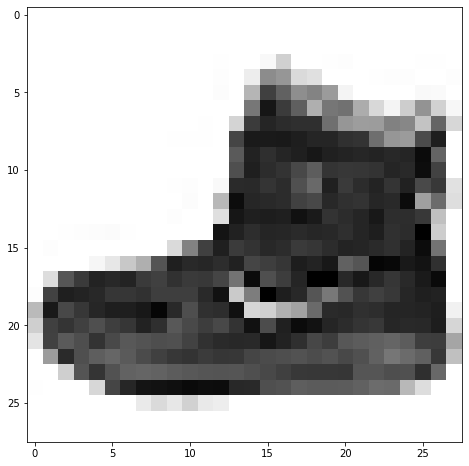

In [156]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [157]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [158]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


In [159]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)

In [160]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

**MY CODE**

**Observing and understanding the dataset**

Labels:  [   0    8    9    3    9    7    6    7    1    0    6    3]


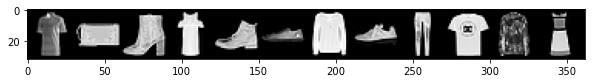

In [161]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [162]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [163]:
transform = transforms.Compose( [transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])

#Load the data: train and test set
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download= True, train = True, transform = transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download = True, train = False, transform = transform)

#Preparing for validation test

indices = list( range(len( trainset)) )
np.random.shuffle(indices)

#to get 20% of the train set as a validation set

split = int( np.floor(0.2*len(trainset)))

train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader

trainloader = torch.utils.data.DataLoader(trainset, sampler = train_sample, batch_size= 64)
validloader = torch.utils.data.DataLoader(trainset, sampler = valid_sample, batch_size= 64 )
testloader = torch.utils.data.DataLoader(testset, batch_size= 64, shuffle=True)


In [164]:
x_train = trainset.data
y_train = trainset.targets

<ipython-input-165-f4145a93121c>:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(4, 20/4, idx + 1, xticks = [], yticks = [])


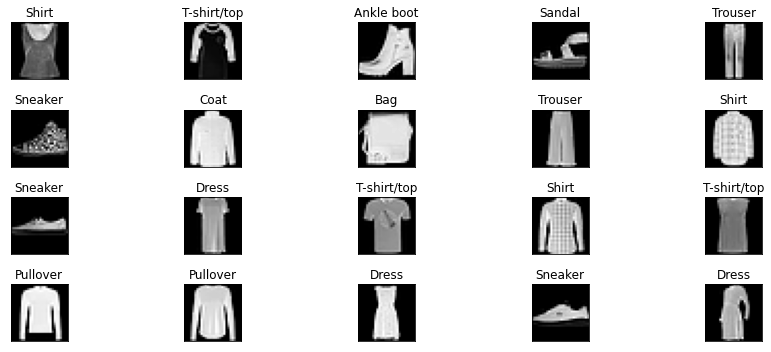

In [165]:
import matplotlib.pyplot as plt
%matplotlib inline

labels_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()

fig = plt.figure( figsize = (15,5))

for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx + 1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(labels_name[labels[idx].item()])
    fig.tight_layout()

**Defining a CNN without regularization**

In [166]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

**Writing a code for the manual training process, then I'll create another more complex regularized model and use cross-validation, gridsearch and more...**

In [195]:
model = ConvolutionalNetwork()
#defining the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

valid_loss_min = np.Inf # using a high value 
epochs = 100
steps = 0
model.train() 

train_losses, valid_losses = [],[]
train_accuracy, valid_accuracy = [], []

for e in range(epochs):
    running_loss = 0
    valid_loss = 0

    #train the model 
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)


    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps,labels)
        valid_loss += loss.item() * images.size(0)

    running_loss = running_loss / len(trainloader.sampler)
    valid_loss = valid_loss / len(validloader.sampler)
    train_losses.append(running_loss)
    train_accuracy.append(1-running_loss)
    valid_losses.append(valid_loss)
    valid_accuracy.append(1-valid_loss)

    print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss {:.6f} Training Accuracy: {:.6f}\tValidation Accuracy {:.6f}'.format(e+1,running_loss,valid_loss,1-running_loss,1-valid_loss))

    if valid_loss <= valid_loss_min:
       #print('validaiton loss decreased ({:.6f} --> {:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
       torch.save(model.state_dict(), 'model.pt')
       valid_loss_min = valid_loss

Epoch: 1 	 Training Loss: 2.293862 	Validation Loss 2.285623 Training Accuracy: -1.293862	Validation Accuracy -1.285623
Epoch: 2 	 Training Loss: 2.267579 	Validation Loss 2.240594 Training Accuracy: -1.267579	Validation Accuracy -1.240594
Epoch: 3 	 Training Loss: 2.130603 	Validation Loss 1.882028 Training Accuracy: -1.130603	Validation Accuracy -0.882028
Epoch: 4 	 Training Loss: 1.420478 	Validation Loss 1.131066 Training Accuracy: -0.420478	Validation Accuracy -0.131066
Epoch: 5 	 Training Loss: 1.012264 	Validation Loss 0.987415 Training Accuracy: -0.012264	Validation Accuracy 0.012585
Epoch: 6 	 Training Loss: 0.887379 	Validation Loss 0.880989 Training Accuracy: 0.112621	Validation Accuracy 0.119011
Epoch: 7 	 Training Loss: 0.804807 	Validation Loss 0.819136 Training Accuracy: 0.195193	Validation Accuracy 0.180864
Epoch: 8 	 Training Loss: 0.752109 	Validation Loss 0.740190 Training Accuracy: 0.247891	Validation Accuracy 0.259810
Epoch: 9 	 Training Loss: 0.705725 	Validation 

Epoch: 70 	 Training Loss: 0.292746 	Validation Loss 0.370186 Training Accuracy: 0.707254	Validation Accuracy 0.629814
Epoch: 71 	 Training Loss: 0.287174 	Validation Loss 0.384785 Training Accuracy: 0.712826	Validation Accuracy 0.615215
Epoch: 72 	 Training Loss: 0.289313 	Validation Loss 0.403426 Training Accuracy: 0.710687	Validation Accuracy 0.596574
Epoch: 73 	 Training Loss: 0.281310 	Validation Loss 0.380512 Training Accuracy: 0.718690	Validation Accuracy 0.619488
Epoch: 74 	 Training Loss: 0.285022 	Validation Loss 0.424780 Training Accuracy: 0.714978	Validation Accuracy 0.575220
Epoch: 75 	 Training Loss: 0.281763 	Validation Loss 0.368330 Training Accuracy: 0.718237	Validation Accuracy 0.631670
Epoch: 76 	 Training Loss: 0.278523 	Validation Loss 0.379881 Training Accuracy: 0.721477	Validation Accuracy 0.620119
Epoch: 77 	 Training Loss: 0.274291 	Validation Loss 0.388615 Training Accuracy: 0.725709	Validation Accuracy 0.611385
Epoch: 78 	 Training Loss: 0.273597 	Validation 

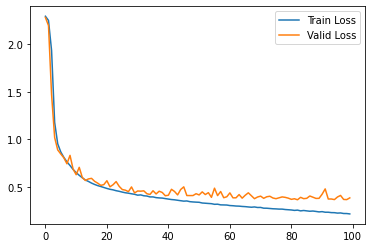

In [192]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(valid_losses, label = 'Valid Loss')

plt.legend()

<ipython-input-196-cf9dfc21a540>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx +1, xticks=[], yticks=[])


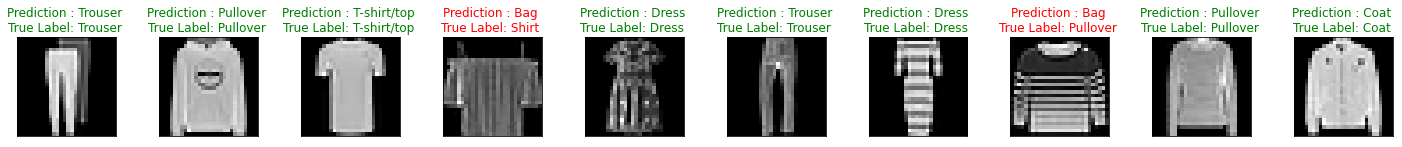

In [196]:
#obtain one batch of the test images
dataiter = iter(testloader)
images, labels = dataiter.next()


output = model(images)
#convert output probabilities to predicted class
_,preds = torch.max(output,1)
#prep images for display
images = images.numpy()

#plotting the images in the batch

fig = plt.figure(figsize=(25,4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx +1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("Prediction : {} \nTrue Label: {} ".format( str(labels_name[preds[idx].item()]),str( labels_name[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))



In [197]:
# First hidden layer
netx = model

h1_w = netx.fc1.weight.data.cpu().numpy()
h1_b = netx.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = netx.fc2.weight.data.cpu().numpy()
h2_b = netx.fc2.bias.data.cpu().numpy()

# Third hidden layer
h3_w = netx.fc3.weight.data.cpu().numpy()
h3_b = netx.fc3.bias.data.cpu().numpy()

# Output layer
#out_w = net.out.weight.data.cpu().numpy()
#out_b = net.out.bias.data.cpu().numpy()

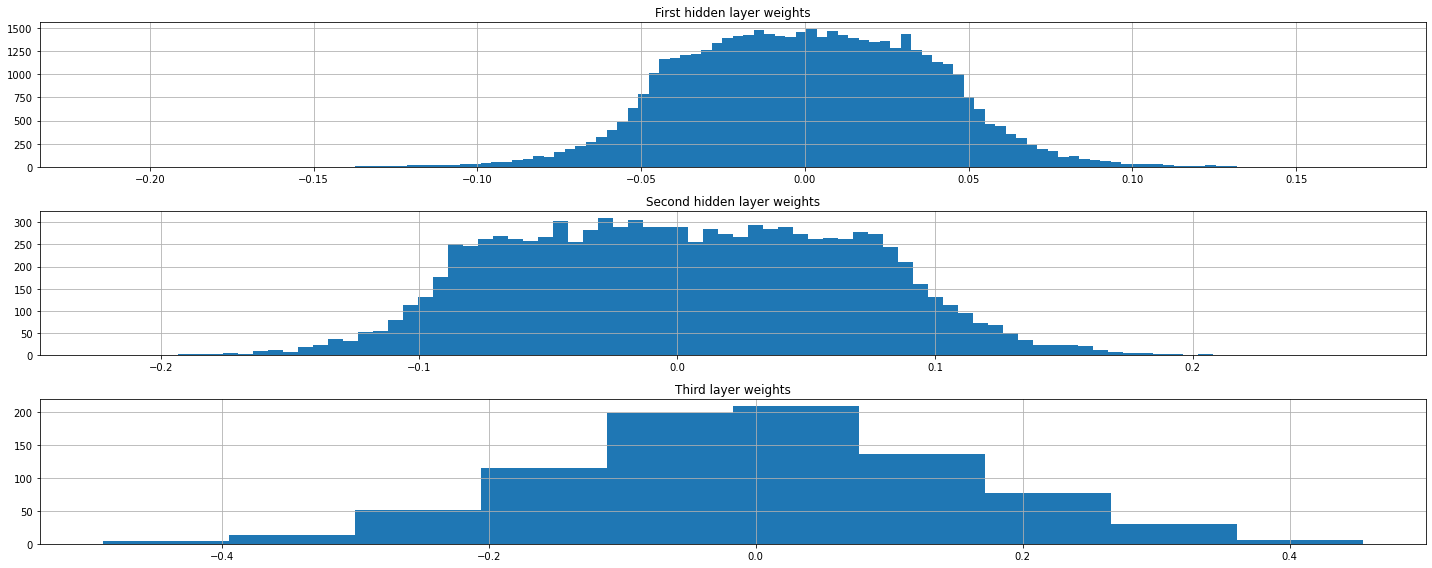

In [54]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(20,8))
axs[0].hist(h1_w.flatten(), len(h1_w))
axs[0].set_title('First hidden layer weights')

axs[1].hist(h2_w.flatten(), len(h2_w))
axs[1].set_title('Second hidden layer weights')

axs[2].hist(h3_w.flatten(), len(h3_w))
axs[2].set_title('Third layer weights')

[ax.grid() for ax in axs]

plt.tight_layout()
plt.show()

[[   0    1    2    3    4    5    6    7    8    9]]



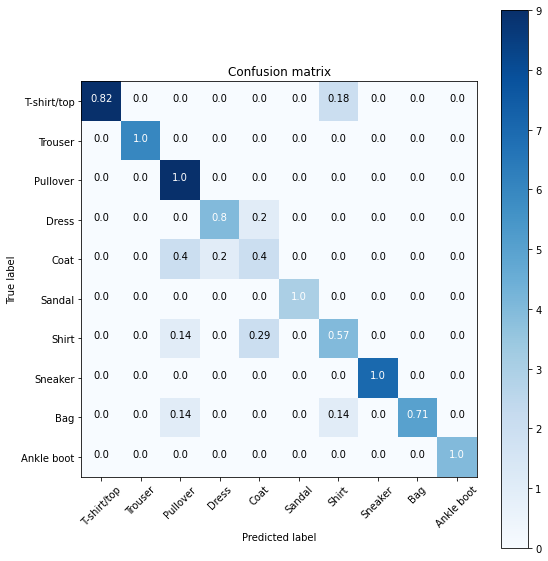

In [198]:
# print a row of values for reference
from sklearn.metrics import confusion_matrix 

np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
cm = confusion_matrix(preds.view(-1), labels.view(-1))

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('int') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
   
plot_confusion_matrix(cm,labels)

In [199]:
#Visualize Filters

model_weights = [] 
conv_layers = [] 
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)


#https://medium.com/dataseries/visualizing-the-feature-maps-and-filters-by-convolutional-neural-networks-e1462340518e

CONV: Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([6, 1, 3, 3])
CONV: Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([16, 6, 3, 3])


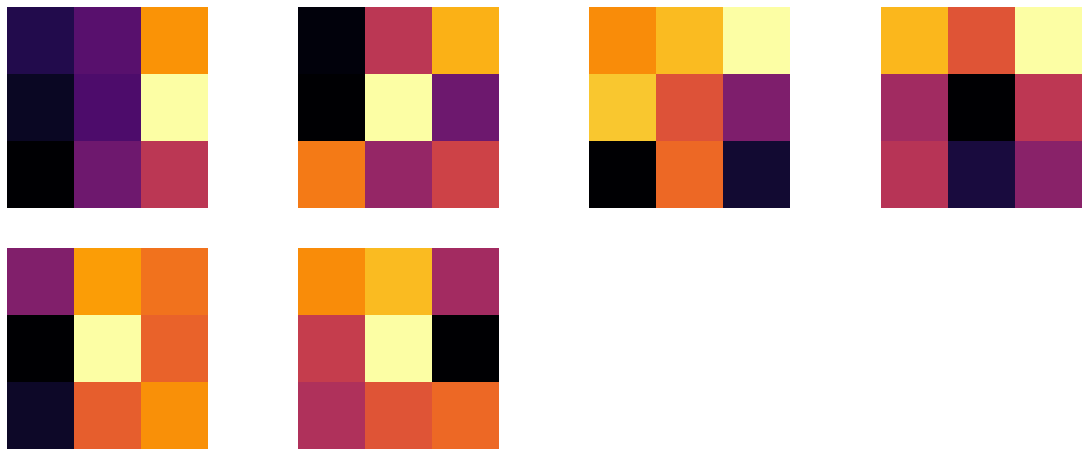

In [200]:

for weight, conv in zip(model_weights, conv_layers):
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

# Visualizing the first convolutional layer filters

plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='inferno')
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

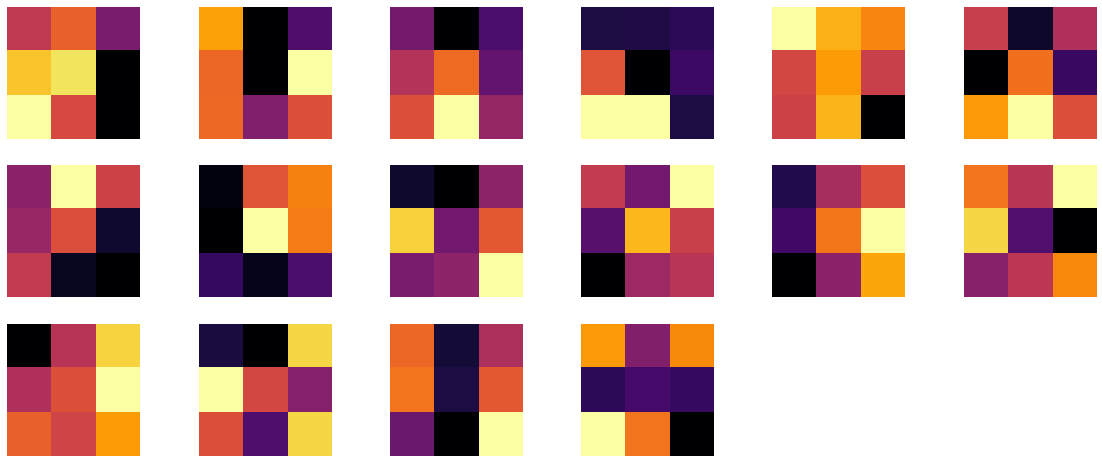

In [201]:
# Visualizing the second convolutional layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(6, 6, i+1) # (8, 8) because in conv0 we have 5x5 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='inferno')
    plt.axis('off')
    plt.savefig('filter2.png')
plt.show()

In [202]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

6


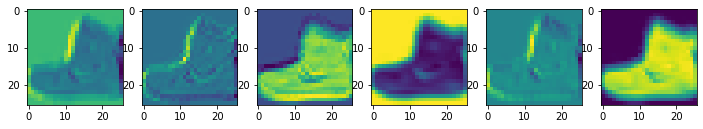

In [203]:
#Visualizing Feature Maps for the first convolutional layer
model.conv1.register_forward_hook(get_activation('conv1'))
data = train_dataset[sample_index][0]
#data=data.to(device)
data.unsqueeze_(0)
output = model(data)

k=0
act = activation['conv1'].squeeze()
fig,ax = plt.subplots(1,6,figsize=(12, 15))

print(act.size(0))
for i in range(act.size(0)):
           ax[i].imshow(act[k].detach().cpu().numpy())
           k+=1    
           plt.savefig('fm1.png')

16


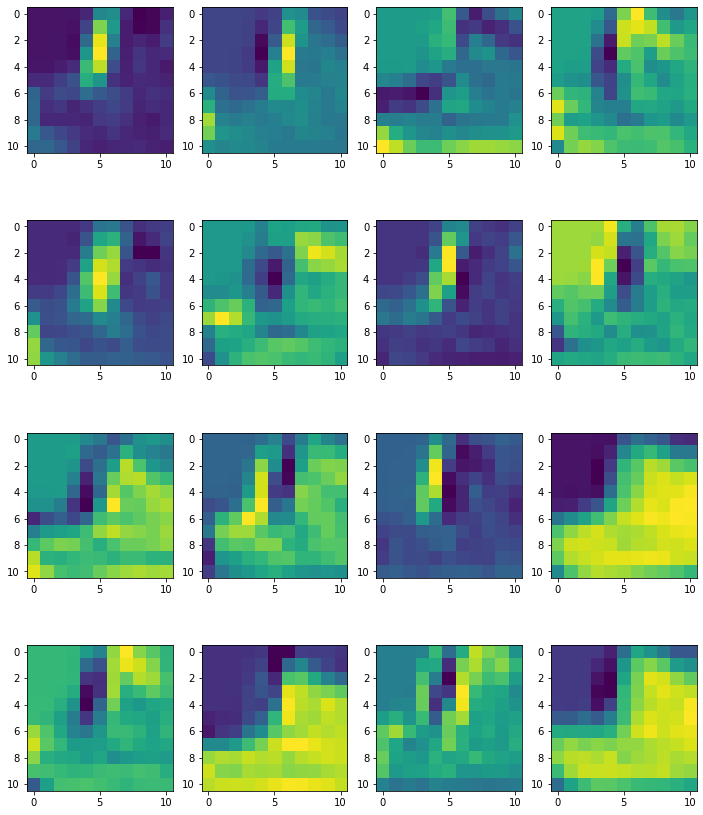

In [204]:
#Visualizing Feature Maps for the second convolution layer
model.conv2.register_forward_hook(get_activation('conv2'))
data = train_dataset[sample_index][0]
#data=data.to(device)
data.unsqueeze_(0)
output = model(data)

k=0
act = activation['conv2'].squeeze()
fig,ax = plt.subplots(4,4,figsize=(12, 15))

print(act.size(0))
for i in range(4):
    for j in range(4):
           ax[i,j].imshow(act[k].detach().cpu().numpy())
           k+=1    
           plt.savefig('fm1.png')
# https://medium.com/dataseries/visualizing-the-feature-maps-and-filters-by-convolutional-neural-networks-e1462340518e

SAMPLE AT INDEX 0
LABEL: 9


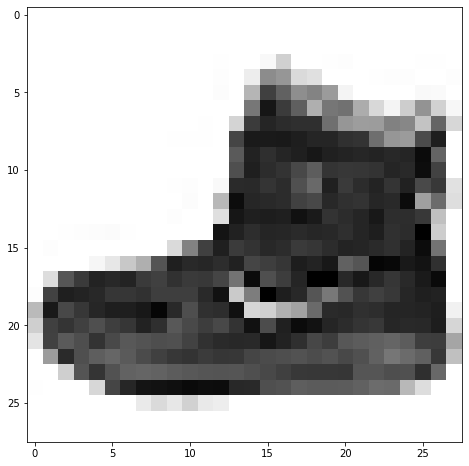

In [205]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image.reshape(28,28), cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

**EXPERIMENTING THE A MORE COMPLEX REGULARIZED CNN MODEL**

In [209]:
# CNN ARCHITECTURE

class ConvolutionalNetworkRegularized(nn.Module):
    def __init__(self):
        super(ConvolutionalNetworkRegularized, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

**Now I'll train the same network with different optimizers and plot a graph which consist of all in order to compare**

In [210]:
#TRYING SGD AS AN OPTIMIZER

model22 = ConvolutionalNetwork()
#defining the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model22.parameters(),lr=0.01)

valid_loss_min = np.Inf # using this high value to make sure the update the weight first time
epochs = 20
steps = 0
model22.train() # prep model for training
train_losses, valid_losses = [],[]
train_accuracy, valid_accuracy = [], []

for e in range(epochs):
    running_loss = 0
    valid_loss = 0

    #train the model number
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model22(images)
        loss = criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)


    for images, labels in validloader:
        log_ps = model22(images)
        loss = criterion(log_ps,labels)
        valid_loss += loss.item() * images.size(0)

    running_loss = running_loss / len(trainloader.sampler)
    valid_loss = valid_loss / len(validloader.sampler)
    train_losses.append(running_loss)
    train_accuracy.append(1-running_loss)
    valid_losses.append(valid_loss)
    valid_accuracy.append(1-valid_loss)

    print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss {:.6f} Training Accuracy: {:.6f}\tValidation Accuracy {:.6f}'.format(e+1,running_loss,valid_loss,1-running_loss,1-valid_loss))

    if valid_loss <= valid_loss_min:
       #print('validaiton loss decreased ({:.6f} --> {:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
       torch.save(model.state_dict(), 'model.pt')
       valid_loss_min = valid_loss
    
sgd_losses = valid_losses

Epoch: 1 	 Training Loss: 2.303628 	Validation Loss 2.302407 Training Accuracy: -1.303628	Validation Accuracy -1.302407
Epoch: 2 	 Training Loss: 2.301202 	Validation Loss 2.300479 Training Accuracy: -1.301202	Validation Accuracy -1.300479
Epoch: 3 	 Training Loss: 2.299061 	Validation Loss 2.298388 Training Accuracy: -1.299061	Validation Accuracy -1.298388
Epoch: 4 	 Training Loss: 2.296491 	Validation Loss 2.295506 Training Accuracy: -1.296491	Validation Accuracy -1.295506
Epoch: 5 	 Training Loss: 2.292716 	Validation Loss 2.290713 Training Accuracy: -1.292716	Validation Accuracy -1.290713
Epoch: 6 	 Training Loss: 2.285904 	Validation Loss 2.281118 Training Accuracy: -1.285904	Validation Accuracy -1.281118
Epoch: 7 	 Training Loss: 2.269938 	Validation Loss 2.254150 Training Accuracy: -1.269938	Validation Accuracy -1.254150
Epoch: 8 	 Training Loss: 2.207372 	Validation Loss 2.115020 Training Accuracy: -1.207372	Validation Accuracy -1.115020
Epoch: 9 	 Training Loss: 1.745929 	Vali

In [211]:
#TRYING ADAM AS AN OPTIMIZER

model = ConvolutionalNetwork()
#defining the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

valid_loss_min = np.Inf # using this high value to make sure the update the weight first time
epochs = 20
steps = 0
model.train() # prep model for training
train_losses, valid_losses = [],[]
train_accuracy, valid_accuracy = [], []

for e in range(epochs):
    running_loss = 0
    valid_loss = 0

    #train the model number
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)


    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps,labels)
        valid_loss += loss.item() * images.size(0)

    running_loss = running_loss / len(trainloader.sampler)
    valid_loss = valid_loss / len(validloader.sampler)
    train_losses.append(running_loss)
    train_accuracy.append(1-running_loss)
    valid_losses.append(valid_loss)
    valid_accuracy.append(1-valid_loss)

    print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss {:.6f} Training Accuracy: {:.6f}\tValidation Accuracy {:.6f}'.format(e+1,running_loss,valid_loss,1-running_loss,1-valid_loss))

    if valid_loss <= valid_loss_min:
       #print('validaiton loss decreased ({:.6f} --> {:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
       torch.save(model.state_dict(), 'model.pt')
       valid_loss_min = valid_loss
adam_losses = valid_losses.copy()

Epoch: 1 	 Training Loss: 0.739294 	Validation Loss 0.566782 Training Accuracy: 0.260706	Validation Accuracy 0.433218
Epoch: 2 	 Training Loss: 0.494125 	Validation Loss 0.475143 Training Accuracy: 0.505875	Validation Accuracy 0.524857
Epoch: 3 	 Training Loss: 0.430543 	Validation Loss 0.470975 Training Accuracy: 0.569457	Validation Accuracy 0.529025
Epoch: 4 	 Training Loss: 0.390045 	Validation Loss 0.445432 Training Accuracy: 0.609955	Validation Accuracy 0.554568
Epoch: 5 	 Training Loss: 0.361278 	Validation Loss 0.401117 Training Accuracy: 0.638722	Validation Accuracy 0.598883
Epoch: 6 	 Training Loss: 0.340500 	Validation Loss 0.431137 Training Accuracy: 0.659500	Validation Accuracy 0.568863
Epoch: 7 	 Training Loss: 0.323488 	Validation Loss 0.455384 Training Accuracy: 0.676512	Validation Accuracy 0.544616
Epoch: 8 	 Training Loss: 0.315627 	Validation Loss 0.433418 Training Accuracy: 0.684373	Validation Accuracy 0.566582
Epoch: 9 	 Training Loss: 0.304738 	Validation Loss 0.42

In [212]:
#TRYING ADAGRAD AS AN OPTIMIZER

model = ConvolutionalNetwork()
#defining the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

valid_loss_min = np.Inf # using this high value to make sure the update the weight first time
epochs = 20
steps = 0
model.train() # prep model for training
train_losses, valid_losses = [],[]
train_accuracy, valid_accuracy = [], []

for e in range(epochs):
    running_loss = 0
    valid_loss = 0

    #train the model number
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)


    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps,labels)
        valid_loss += loss.item() * images.size(0)

    running_loss = running_loss / len(trainloader.sampler)
    valid_loss = valid_loss / len(validloader.sampler)
    train_losses.append(running_loss)
    train_accuracy.append(1-running_loss)
    valid_losses.append(valid_loss)
    valid_accuracy.append(1-valid_loss)

    print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss {:.6f} Training Accuracy: {:.6f}\tValidation Accuracy {:.6f}'.format(e+1,running_loss,valid_loss,1-running_loss,1-valid_loss))

    if valid_loss <= valid_loss_min:
       #print('validaiton loss decreased ({:.6f} --> {:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
       torch.save(model.state_dict(), 'model.pt')
       valid_loss_min = valid_loss
adagrad_losses = valid_losses.copy()

Epoch: 1 	 Training Loss: 0.853250 	Validation Loss 0.672446 Training Accuracy: 0.146750	Validation Accuracy 0.327554
Epoch: 2 	 Training Loss: 0.577895 	Validation Loss 0.586021 Training Accuracy: 0.422105	Validation Accuracy 0.413979
Epoch: 3 	 Training Loss: 0.520158 	Validation Loss 0.515953 Training Accuracy: 0.479842	Validation Accuracy 0.484047
Epoch: 4 	 Training Loss: 0.485224 	Validation Loss 0.498432 Training Accuracy: 0.514776	Validation Accuracy 0.501568
Epoch: 5 	 Training Loss: 0.462080 	Validation Loss 0.473254 Training Accuracy: 0.537920	Validation Accuracy 0.526746
Epoch: 6 	 Training Loss: 0.443511 	Validation Loss 0.474158 Training Accuracy: 0.556489	Validation Accuracy 0.525842
Epoch: 7 	 Training Loss: 0.427507 	Validation Loss 0.474732 Training Accuracy: 0.572493	Validation Accuracy 0.525268
Epoch: 8 	 Training Loss: 0.413932 	Validation Loss 0.443706 Training Accuracy: 0.586068	Validation Accuracy 0.556294
Epoch: 9 	 Training Loss: 0.401324 	Validation Loss 0.43

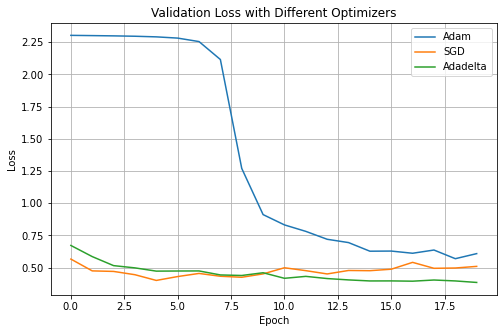

In [213]:
plt.figure(figsize=(8,5))
plt.plot(range(epochs),sgd_losses, label = 'Adam')
plt.plot(range(epochs),adam_losses, label = 'SGD')
plt.plot(range(epochs),adagrad_losses, label = 'Adadelta')


plt.legend()
plt.title('Validation Loss with Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [216]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim= 28*28*1,
            hidden_dim= 98,
            output_dim= 10,
            dropout=0.5
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

torch.manual_seed(0)

netf = NeuralNetClassifier(
    ClassifierModule
    
)
params = { 'lr' : [0.001,0.005,0.01], 'max_epochs': [50,100]}

grid_model_fin = GridSearchCV(netf,params,refit=False,scoring='r2',verbose=1,cv=4)

grid_model_fin.fit(x_train, y_train);



Fitting 4 folds for each of 6 candidates, totalling 24 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.5749       0.6853        0.8065  0.7300
      2        1.0666       0.7141        0.7069  0.7263
      3        0.9659       0.6950        0.7319  0.7091
      4        0.9037       0.7701        0.6159  0.7128
      5        0.8736       0.7429        0.6358  0.7194
      6        0.8313       0.7302        0.7090  0.7328
      7        0.7996       0.7419        0.6519  0.7264
      8        0.7816       0.7973        0.5841  0.7507
      9        0.7629       0.7854        0.5811  0.7631
     10        0.7441       0.7479        0.7265  0.7226
     11        0.7277       0.8014        0.5622  0.7273
     12        0.7262       0.7982        0.5495  0.7363
     13        0.7088       0.7481        0.6278  0.7336
     14        0.7008       0.7799        0.5644  0.7191
     15        0.7009       

     12        0.6938       0.8233        0.5226  0.8035
     13        0.6873       0.7747        0.6230  0.8255
     14        0.6883       0.8117        0.5407  0.7309
     15        0.6680       0.8129        0.5168  0.7371
     16        0.6647       0.7989        0.5406  0.7420
     17        0.6529       0.7650        0.5763  0.7442
     18        0.6458       0.8198        0.5116  0.7632
     19        0.6430       0.7537        0.5895  0.7674
     20        0.6318       0.7888        0.5526  0.8408
     21        0.6217       0.7941        0.5461  0.7401
     22        0.6155       0.7852        0.5270  0.7601
     23        0.6152       0.8279        0.4884  0.7500
     24        0.6051       0.7964        0.5102  0.7473
     25        0.5988       0.8274        0.4891  0.7424
     26        0.5955       0.8409        0.4599  0.7666
     27        0.5960       0.8380        0.4660  0.7513
     28        0.5822       0.8321        0.4747  0.7526
     29        0.5841       0.8

     29        0.5526       0.8270        0.4987  0.8107
     30        0.5518       0.7914        0.5399  0.7513
     31        0.5481       0.8320        0.4847  0.7823
     32        0.5367       0.8441        0.4644  0.7474
     33        0.5452       0.8314        0.4847  0.7853
     34        0.5381       0.8196        0.4923  0.7908
     35        0.5284       0.8459        0.4530  0.7474
     36        0.5317       0.8204        0.4872  0.7360
     37        0.5212       0.8201        0.4844  0.7630
     38        0.5274       0.8342        0.4852  0.7468
     39        0.5232       0.8454        0.4433  0.7375
     40        0.5149       0.8414        0.4558  0.7453
     41        0.5133       0.7858        0.5653  0.7585
     42        0.5121       0.8374        0.4621  0.7467
     43        0.5087       0.8251        0.4851  0.7333
     44        0.5067       0.8349        0.4662  0.7492
     45        0.5010       0.8371        0.4592  0.7636
     46        0.5034       0.8

     51        0.4936       0.8361        0.4590  1.0324
     52        0.4964       0.8523        0.4309  1.1033
     53        0.4927       0.8531        0.4274  1.7893
     54        0.4967       0.8167        0.4914  1.3484
     55        0.4903       0.8498        0.4340  1.1740
     56        0.4871       0.8269        0.4686  1.9551
     57        0.4892       0.8483        0.4322  1.8635
     58        0.4797       0.8454        0.4412  2.0708
     59        0.4797       0.8471        0.4380  1.7919
     60        0.4845       0.8459        0.4456  0.9244
     61        0.4829       0.8428        0.4406  0.9606
     62        0.4804       0.8446        0.4429  0.9072
     63        0.4789       0.8470        0.4407  0.8371
     64        0.4740       0.8536        0.4290  0.7860
     65        0.4757       0.8437        0.4485  0.7755
     66        0.4708       0.8483        0.4307  0.7698
     67        0.4733       0.8510        0.4350  0.7659
     68        0.4690       0.8

     73        0.4881       0.8473        0.4369  1.0895
     74        0.4816       0.8281        0.4787  1.8462
     75        0.4803       0.8451        0.4588  1.7905
     76        0.4786       0.8578        0.4176  1.6347
     77        0.4801       0.8541        0.4282  1.3474
     78        0.4783       0.8446        0.4389  1.4785
     79        0.4718       0.8448        0.4494  1.2733
     80        0.4756       0.8500        0.4342  1.0382
     81        0.4729       0.8437        0.4399  0.9421
     82        0.4764       0.8482        0.4389  0.8691
     83        0.4759       0.8498        0.4354  1.0315
     84        0.4672       0.8576        0.4231  0.8973
     85        0.4687       0.8427        0.4540  0.8678
     86        0.4666       0.8230        0.4868  0.8789
     87        0.4654       0.8468        0.4489  1.0995
     88        0.4610       0.8476        0.4413  0.9780
     89        0.4644       0.8541        0.4336  0.9470
     90        0.4667       0.8

     99        0.4300       0.7641        0.8321  0.7586
    100        0.4258       0.7549        1.1451  0.7716
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        9.7505       0.3063        2.8069  0.8027
      2        1.6106       0.6009        1.2273  0.7532
      3        1.4813       0.5544        1.3418  0.8007
      4        1.4824       0.5362        1.2983  0.8401
      5        1.4628       0.5484        1.2564  0.8627
      6        1.4140       0.6284        1.3086  0.9056
      7        1.3737       0.5944        1.1530  0.8077
      8        1.3047       0.6667        1.0075  0.9538
      9        1.2945       0.5893        1.4376  1.0139
     10        1.2376       0.6401        1.0378  0.9791
     11        1.2565       0.7006        0.9674  0.9119
     12        1.2343       0.6626        0.9471  1.1032
     13        1.2280       0.6758        0.9515  0.8600
     14        1.2381       0.6

     20        1.0996       0.7452        0.8182  1.1478
     21        1.0673       0.7220        1.0396  1.0172
     22        1.0523       0.6982        0.9497  1.0931
     23        1.0990       0.6970        0.9124  0.9409
     24        1.1349       0.6592        0.9716  0.9262
     25        1.2019       0.7042        0.9257  0.9569
     26        1.1425       0.6492        1.0644  1.1090
     27        1.1432       0.7262        0.8672  1.1693
     28        1.1254       0.7199        0.8535  1.0419
     29        1.1003       0.7382        0.8133  0.9379
     30        1.0948       0.7386        0.8472  1.0208
     31        1.1070       0.6810        1.1469  0.8410
     32        1.0895       0.7468        0.8101  0.8208
     33        1.0421       0.7346        0.8655  0.8106
     34        1.0620       0.7266        0.8274  0.8137
     35        1.0810       0.7090        0.8398  0.8223
     36        1.0532       0.7366        0.8835  0.8029
     37        1.0388       0.7

     45        1.3105       0.6448        0.9194  1.0104
     46        1.2510       0.6401        0.9311  0.8557
     47        1.2598       0.6113        1.0272  0.8131
     48        1.2756       0.6318        1.0971  1.0365
     49        1.2513       0.6464        0.9260  0.9423
     50        1.2438       0.6400        0.9461  1.3992
     51        1.2296       0.6438        1.0217  1.2385
     52        1.2090       0.6500        1.0201  0.9282
     53        1.2292       0.5660        1.6362  1.0006
     54        1.3018       0.6470        0.9650  0.8888
     55        1.2726       0.6646        0.9234  0.8814
     56        1.3705       0.6526        1.0522  0.8084
     57        1.2169       0.6831        0.9256  0.7837
     58        1.2200       0.6591        0.9032  0.8478
     59        1.2015       0.6420        0.9507  0.7800
     60        1.2492       0.6770        0.8912  0.7756
     61        1.2013       0.6476        0.9186  0.7811
     62        1.2190       0.6

     79        0.8571       0.7426        0.7232  0.7681
     80        0.8645       0.7634        0.6997  0.8223
     81        0.8878       0.7503        0.7068  0.8263
     82        0.8800       0.7640        0.7023  0.7866
     83        0.8804       0.7014        1.3558  0.8213
     84        0.9066       0.7337        1.1304  0.8222
     85        0.9026       0.7372        0.7499  0.7623
     86        0.8948       0.7538        0.6968  0.7944
     87        0.8762       0.7538        0.7213  0.8032
     88        0.8943       0.7646        0.7814  0.8071
     89        0.8598       0.7600        0.7154  0.8201
     90        0.9059       0.7591        0.7442  0.8004
     91        0.8504       0.7279        0.7396  0.8224
     92        0.8513       0.7661        0.7147  0.7881
     93        0.8583       0.8118        0.7336  1.1586
     94        0.8831       0.7541        0.8005  0.7696
     95        0.8953       0.7590        0.7314  0.8213
     96        0.8778       0.7

      8        1.1396       0.7022        0.9601  0.8330
      9        1.1317       0.7078        0.8944  0.7549
     10        1.0742       0.7006        0.9310  0.8006
     11        1.0968       0.6951        0.9018  0.7816
     12        1.1195       0.6990        0.8814  0.8140
     13        1.0754       0.7161        0.8390  0.7702
     14        1.0529       0.6447        1.0919  0.8353
     15        1.0610       0.7034        0.8506  0.7771
     16        1.0299       0.6951        0.8902  0.7703
     17        1.0454       0.7132        0.8567  0.7816
     18        1.0173       0.7026        0.8336  0.7621
     19        1.0146       0.6868        0.8861  0.7689
     20        1.0014       0.6917        0.8452  0.7628
     21        1.0135       0.6843        0.8848  0.7923
     22        1.0128       0.6501        0.9162  0.8495
     23        1.0114       0.6782        0.9229  0.8038
     24        1.0061       0.6834        0.8426  0.8818
     25        0.9711       0.6

     41       11.4446       0.2862       11.3793  0.8270
     42       11.4356       0.2872       11.3634  0.7831
     43       11.3764       0.2867       11.3722  0.7645
     44       11.3906       0.2866       11.3740  0.7765
     45       11.3530       0.2874       11.3598  0.8090
     46       11.2809       0.2892       11.3315  0.8060
     47       11.1484       0.2914       11.2948  0.7755
     48       11.1090       0.2901       11.3173  0.7784
     49       11.2700       0.2892       11.3315  0.7432
     50       11.1461       0.2896       11.3262  0.8022
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       12.1422       0.2900       11.3145  0.7965
      2       11.7596       0.2169       12.4736  0.7539
      3       11.9089       0.2968       11.1996  0.7812
      4       11.4221       0.3134       10.9419  0.8356
      5       11.1888       0.3126       10.9556  0.8129
      6       11.7595       0.2

     11        1.8374       0.3696        1.6694  1.3291
     12        1.8987       0.3060        1.7823  1.0510
     13        1.8532       0.3704        2.1266  0.8616
     14        1.8266       0.3964        1.6602  0.8141
     15        1.8143       0.4404        1.6365  0.8197
     16        1.7991       0.3988        1.6906  0.8490
     17        1.8009       0.3983        1.6212  1.3006
     18        1.7896       0.3638        1.6429  0.8563
     19        1.7893       0.4016        1.6776  0.8070
     20        1.7945       0.3889        1.7160  0.7908
     21        1.7737       0.3684        1.6454  0.8239
     22        1.7758       0.3952        1.6039  0.8139
     23        1.7511       0.3944        1.6021  0.8221
     24        1.7740       0.3919        1.6275  0.7960
     25        1.7632       0.3918        1.5930  0.8805
     26        1.7663       0.4070        1.6043  0.8500
     27        1.7701       0.3934        1.6050  0.7999
     28        1.7740       0.3

     92        1.9841       0.2593        1.9661  1.0210
     93        1.9993       0.2586        1.9497  0.9852
     94        1.9810       0.2554        1.9564  0.9629
     95        1.9755       0.2662        1.9677  0.9683
     96        1.9836       0.2508        1.9462  0.8009
     97        1.9690       0.2628        1.9597  0.7805
     98        1.9821       0.2581        1.9442  0.7913
     99        1.9620       0.2670        1.9515  0.8235
    100        1.9695       0.2521        1.9591  0.7968
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       12.3463       0.3582       10.2115  0.7780
      2       11.6212       0.3191       10.8440  0.7928
      3        8.7035       0.2100        2.5432  0.8427
      4        2.2804       0.2966        2.1107  0.7982
      5        2.1570       0.2524        1.9812  1.0509
      6        2.1024       0.2369        1.9885  1.1138
      7        2.0684       0.2

     22        8.3473       0.5084        7.8344  0.8717
     23        8.1987       0.5121        7.7736  0.9356
     24        9.2511       0.4758        8.3565  0.8440
     25        8.8699       0.5026        7.9305  0.8909
     26        8.6917       0.4689        8.4649  0.8476
     27        8.9621       0.4850        8.2103  0.8678
     28        8.4897       0.5190        7.6667  0.8348
     29        8.5552       0.4933        8.0758  0.8195
     30        8.2955       0.4989        7.9883  0.8420
     31        8.2364       0.5252        7.5686  0.8351
     32        8.6417       0.4310        9.0684  0.8641
     33        8.6625       0.5132        7.7604  0.8421
     34        8.2877       0.5044        7.9003  0.8469
     35        8.2778       0.5248        7.5745  0.8190
     36        8.5622       0.4997        7.9738  0.8795
     37        8.3197       0.5067        7.8612  0.8313
     38        8.2130       0.5248        7.5740  0.8168
     39        8.0255       0.5

     48        1.7545       0.3843        1.6278  1.2079
     49        1.7204       0.4291        1.5720  1.1722
     50        1.7733       0.4333        1.5656  1.2858
     51        1.7294       0.4064        1.6112  1.1817
     52        1.7415       0.4258        1.5628  1.1752
     53        1.7377       0.3760        1.6437  1.3625
     54        1.7644       0.3682        1.6520  1.4523
     55        1.7628       0.4318        1.5645  1.4665
     56        1.8147       0.4562        1.6381  1.1319
     57        1.7686       0.4147        1.5970  1.0057
     58        1.7475       0.4254        1.5784  0.8569
     59        1.7621       0.4082        1.5850  0.8512
     60        1.7608       0.4494        1.5822  0.7919
     61        1.7684       0.4200        1.7579  0.7883
     62        1.7675       0.4247        1.6050  0.8410
     63        1.7563       0.4451        1.5641  0.8901
     64        1.7421       0.4131        1.5852  0.8183
     65        1.7210       0.4

In [214]:
from skorch import NeuralNetClassifier

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download= True, train = True, transform = transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download = True, train = False, transform = transform)

x_train = trainset.data
y_train = trainset.targets

x_train = x_train.reshape(60000,784).float()
y_train = y_train.long()

print(x_train.shape,y_train.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [217]:
print("Best parameters set found:")

print(grid_model_fin.best_params_)

print("Score with best parameters:")

print(abs(grid_model_fin.best_score_))

print("All scores on the grid:")

all_scores = pd.DataFrame(grid_model_fin.cv_results_)

all_scores

Best parameters set found:
{'lr': 0.005, 'max_epochs': 100}
Score with best parameters:
0.7382888888888889
All scores on the grid:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_max_epochs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,39.970908,0.776347,0.223349,0.017138,0.001,50,"{'lr': 0.001, 'max_epochs': 50}",0.721083,0.731095,0.749745,0.647055,0.712244,0.039018,3
1,102.958351,16.817468,0.252031,0.051510,0.001,100,"{'lr': 0.001, 'max_epochs': 100}",0.746465,0.783693,0.753988,0.658974,0.735780,0.046477,2
2,47.109672,2.732949,0.248734,0.048671,0.005,50,"{'lr': 0.005, 'max_epochs': 50}",0.760703,0.529438,0.761172,0.750578,0.700473,0.098837,4
3,89.822303,6.280389,0.318599,0.174821,0.005,100,"{'lr': 0.005, 'max_epochs': 100}",0.765543,0.759741,0.775911,0.651960,0.738289,0.050178,1
4,44.138224,5.020527,0.310268,0.141678,0.01,50,"{'lr': 0.01, 'max_epochs': 50}",-0.066141,0.165042,0.149665,-0.103725,0.036210,0.121991,6
5,104.677158,13.949770,0.230962,0.020468,0.01,100,"{'lr': 0.01, 'max_epochs': 100}",0.055216,0.184695,0.301398,-0.212663,0.082162,0.191197,5
